In [1]:
#!pip install astropy
#!pip install specutils
#!pip install scikit-learn

In [2]:
from astropy import units as u
from specutils import Spectrum1D
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

In [3]:
lineas_espectrales = {
"Halfa":6562.8,
#"Brackett Gamma":21654.9,
"Hbeta": 4861.3,
#"Br Beta":21660.7,
#"Br 11": 19450.6,
#"Br 12":18795.6,
#"Br 14":16804.7,
"NII":6549.86,
"NIIb":6585.27,    
"OI":6300,
"He I": 5875.6,
"He I b":7067,
"He I c":6678,
"He I d":5016,
"He I e":4471,  
"Na D":5895.9,
"Ca II H":3933.7,
"Ca II K":3968.5,
"Li":6707,
"Li b":6709,
"SII":6718.2,
"SIIb":6732.6    
}

In [4]:
%store lineas_espectrales

Stored 'lineas_espectrales' (dict)


In [5]:
import requests
import os
import re
import gzip
from urllib.parse import unquote

def descargar_archivos(url_file, destination_dir, extension):
    # Asegurarse de que el directorio destino existe
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Leer el archivo que contiene las URLs
    with open(url_file, 'r') as file:
        urls = file.readlines()

    for url in urls:
        url = url.strip()  # Eliminar espacios en blanco y saltos de línea
        if url:
            try:
                # Realizar la petición GET
                response = requests.get(url, stream=True)
                response.raise_for_status()  # Lanzar excepción para respuestas no exitosas

                # Intentar obtener el nombre del archivo del encabezado 'Content-Disposition'
                if 'Content-Disposition' in response.headers:
                    content_disp = response.headers['Content-Disposition']
                    matches = re.findall(r'filename\*?="?([^"]+)"?;?', content_disp)
                    if matches:
                        filename = unquote(matches[0])
                    else:
                        raise ValueError("No se pudo extraer el nombre del archivo.")
                else:
                    filename = url.split('/')[-1].split('?')[0]  # Eliminar parámetros de la URL

                # Verificar si el archivo tiene la extensión deseada
                if not filename.lower().endswith(f'.{extension.lower()}'):
                    print(f"Archivo omitido (extensión no coincide): {filename}")
                    continue  # Saltar al siguiente archivo

                # Ruta completa para guardar el archivo
                filepath = os.path.join(destination_dir, filename)

                # Verificar si el archivo es un archivo gz
                if filename.lower().endswith('.gz'):
                    # Descomprimir el contenido
                    with gzip.open(response.raw, 'rb') as gz_file:
                        content = gz_file.read()
                    # Guardar el contenido descomprimido, eliminando la extensión .gz
                    filepath = filepath[:-3]
                else:
                    content = response.content

                # Guardar el contenido en un archivo en el directorio especificado
                with open(filepath, 'wb') as f:
                    f.write(content)
                
                print(f"Descargado y procesado: {filepath}")
            except (requests.RequestException, ValueError) as e:
                print(f"Error al descargar {url}: {e}")

# Uso de la función
#descargar_archivos("..\\Catalogos\\vizier\\NGC2264\\162-Sousa-descarga(Lamost12).txt","..\\Catalogos\\vizier\\NGC2264\\fits2\\","fits.gz")

In [6]:
#descargar_archivos("..\\Catalogos\\LamostNotTTauri\\Otras regiones\\3010-notTTauri-descargas.txt","..\\Catalogos\\LamostNotTTauri\\Otras regiones\\fits2\\","fits.gz")

In [7]:
#descargar_archivos("..\\Catalogos\\vizier\\C-CW-W\\Classic-Sousa-Descarga.txt","..\\Catalogos\\vizier\\C-CW-W\\Sousa\\Classic\\fits\\","fits.gz")

In [8]:
#descargar_archivos("..\\Catalogos\\vizier\\C-CW-W\\ClassicWeak-Serna-Descarga.txt","..\\Catalogos\\vizier\\C-CW-W\\Serna\\ClassicWeak\\fits\\","fits.gz")

In [9]:
import os
import shutil  # Importar shutil para operaciones de copia de archivos
from astropy.io import fits

def esta_normalizado(hdul):
    # Esta función determina si el archivo FITS está normalizado 
    # hdul representa un objeto HDUList obtenido al abrir un archivo FITS.
    data = hdul[1].data[0][5]
    return abs(data.mean() - 1) < 0.2

def selecciona_normalizados(directorio):
    # Recorrer todos los archivos en el directorio especificado

    for filename in os.listdir(directorio):
        filepath = os.path.join(directorio, filename)
        
        if filepath.endswith('.fits'):
            try:
                # Utilizando 'with' para asegurar que el archivo se cierra correctamente
                with fits.open(filepath) as hdul:
                    if esta_normalizado(hdul):
                        new_filename = f"norm_{filename}"
                        new_filepath = os.path.join(directorio, new_filename)
                        # Copiar el archivo original al nuevo nombre
                        shutil.copy(filepath, new_filepath)
                        print(f"Archivo creado: {new_filename}")
            except Exception as e:
                print(f"No se pudo procesar el archivo {filename}: {e}")

# Llamada a la función
#selecciona_normalizados("..\\Catalogos\\vizier\\NGC2264\\fits2\\")


In [10]:
#descargar_archivos("..\\Catalogos\\vizier\\C-CW-W\\Weak-Briceño-Descarga.txt","..\\Catalogos\\vizier\\C-CW-W\\Briceño\\Weak\\fits\\","fits.gz")
#selecciona_normalizados("..\\Catalogos\\vizier\\C-CW-W\\Briceño\\Weak\\fits\\")

In [11]:
def leer_archivos_txt(directorio):
    # Recorrer todos los archivos en el directorio especificado
    for filename in os.listdir(directorio):
        if filename.endswith('.txt'):
            # Construir la ruta completa del archivo
            filepath = os.path.join(directorio, filename)
            # Llamar a la función que procesa cada archivo
            descargar_archivos(filepath,f"{directorio}//fits2//","fits.gz")
            
    selecciona_normalizados(f"{directorio}\\fits2\\")
    
# Llamada a la función
#leer_archivos_txt("..\\Catalogos\\vizier\\OtrasRegiones\\")

In [12]:
def read_spectrum_fits(file_path):
    """
    Reads a .fits file containing a spectrum and returns the header, wavelength array, and intensity array.
    
    Args:
    file_path (str): The path to the .fits file.
    
    Returns:
    tuple: A tuple containing the header, wavelength array, and intensity array.
    """
    
    with fits.open(file_path) as hdul:
        # Los datos del espectro están en el primer HDU
        data = hdul[1].data [0][5]
        header = hdul[1].header
        wavelength = hdul[1].data[0][2]
        
        # El espectro está en el primer (y único) array de datos
        intensity = data[0] if len(data.shape) > 1 else data
    
    return header, wavelength, intensity  

In [13]:
def radec_header_fits(file_path):
    """
    Reads a .fits file containing a spectrum and returns the header, wavelength array, and intensity array.
    
    Args:
    file_path (str): The path to the .fits file.
    
    Returns:
    tuple: A tuple containing the header, wavelength array, and intensity array.
    """
   
    with fits.open(file_path) as hdul:
        
        header = hdul[0].header
        header
       
        return header['RA'],header['DEC']
        

In [14]:
def keyword_header_fits(file_path,keyword):
    
    with fits.open(file_path) as hdul:
        # Asume que los datos del espectro están en el primer HDU
        header = hdul[0].header
        return(header[keyword])

In [15]:
keyword_header_fits("..\\Catalogos\\vizier\\C-CW-W\\Classic\\fits2\\norm_spec-56617-VB081S05V1_sp15-236.fits","OBSID")

181115236

In [16]:
radec_header_fits("..\\Catalogos\\vizier\\C-CW-W\\Classic\\fits2\\norm_spec-56617-VB081S05V1_sp15-236.fits")


(80.765933, -4.678835)

In [17]:
#!pip install pandas
import os
import pandas as pd

def data_dir(path):

  
# Comprobar si el directorio existe
    
    if not os.path.exists(path):
        print("El directorio especificado no existe.")
        return
       
    # Recorrer los ficheros en el directorio
    for filename in os.listdir(path):
        #print(filename)
        if filename.endswith(".fits"):
             radec_header_fits(f"{path}{filename}")
            

In [18]:
#file = "spec-55960-GAC_101N09_V1_sp03-066.fits"
path = "..\\Catalogos\\vizier\\NGC2264\\fits2\\"
#file_path = (f"{path}{file}")
#read_header_fits(file_path)
data_dir(path)

In [19]:
def extract_spectrum_area(wavelengths,intensities,central_wavelength,width):
        
    # Determinar el rango de píxeles que cubren el área de interés
    central_index = np.abs(wavelengths - central_wavelength).argmin()
    half_width_pixels = int(width / 2)
   
    start_index = max(0, central_index - half_width_pixels)
    end_index = min(len(wavelengths), central_index + half_width_pixels)
    
    # Extraer el área del espectro de interés
    sub_wavelengths = wavelengths[start_index:end_index]
    sub_intensities = intensities[start_index:end_index]
    
    return sub_wavelengths,sub_intensities

In [20]:
# Prueba

file = "spec-55960-GAC_101N09_V1_sp05-183.fits"
path = "..\\Spectra\\"
file_path = (f"{path}{file}")
header, wavelength, intensity = read_spectrum_fits(file_path)
print(header)
print(wavelength)
print(intensity)

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11b          BITPIX  =                    8 /Required value                                  NAXIS   =                    2 /Required value                                  NAXIS1  =                89976 /Number of bytes per row                         NAXIS2  =                    1 /Number of rows                                  PCOUNT  =                    0 /Normally 0 (no varying arrays)                  GCOUNT  =                    1 /Required value                                  TFIELDS =                    6 /Number of columns in table                      COMMENT                                                                         COMMENT  *** End of mandatory fields ***                                        COMMENT                                                                         EXTNAME = 'COADD   '           / The extension name                             COMMENT                                 

In [21]:
subw,subi = extract_spectrum_area(wavelength,intensity,6562.8,20)
print(subw)
print(subi)

[6547.8696 6549.3774 6550.8853 6552.394  6553.903  6555.412  6556.922
 6558.4316 6559.942  6561.4526 6562.964  6564.475  6565.987  6567.499
 6569.011  6570.524  6572.037  6573.551  6575.0645 6576.5786]
[0.95454824 0.94889253 0.97789854 0.9799991  0.95636255 0.9184283
 0.9123252  0.90847015 0.9187058  0.82688236 0.7305249  0.6802914
 0.79975915 0.89032835 0.9176394  0.93527985 0.9191853  0.94590825
 0.9378178  0.9382978 ]


In [22]:
def extract_lines_spectrum (lines,file,width):
    
    header,wavelengths,intensities = read_spectrum_fits (file)
    file_lines = {label: extract_spectrum_area(wavelengths,intensities,lines[label],width) for label in lines}
    return file_lines

In [23]:
extract_lines_spectrum (lineas_espectrales,file_path,20)

{'Halfa': (array([6547.8696, 6549.3774, 6550.8853, 6552.394 , 6553.903 , 6555.412 ,
         6556.922 , 6558.4316, 6559.942 , 6561.4526, 6562.964 , 6564.475 ,
         6565.987 , 6567.499 , 6569.011 , 6570.524 , 6572.037 , 6573.551 ,
         6575.0645, 6576.5786], dtype='>f4'),
  array([0.95454824, 0.94889253, 0.97789854, 0.9799991 , 0.95636255,
         0.9184283 , 0.9123252 , 0.90847015, 0.9187058 , 0.82688236,
         0.7305249 , 0.6802914 , 0.79975915, 0.89032835, 0.9176394 ,
         0.93527985, 0.9191853 , 0.94590825, 0.9378178 , 0.9382978 ],
        dtype='>f4')),
 'Hbeta': (array([4850.651 , 4851.7676, 4852.8853, 4854.0024, 4855.1206, 4856.2383,
         4857.357 , 4858.4756, 4859.594 , 4860.7134, 4861.8325, 4862.952 ,
         4864.0723, 4865.1924, 4866.3125, 4867.433 , 4868.554 , 4869.6753,
         4870.797 , 4871.9185], dtype='>f4'),
  array([0.89043707, 0.92219216, 0.9185712 , 0.8860547 , 0.8344626 ,
         0.78257966, 0.7777446 , 0.8196168 , 0.77522403, 0.66228986,
  

In [24]:
import numpy as np

def identify_spectral_lines(wavelengths, intensities, interest_wavelength):
    """
    Identifies emission or absorption lines near a specified wavelength in a spectrum.
    
    Args:
    wavelengths (numpy.array): An array of wavelength values.
    intensities (numpy.array): An array of intensity values corresponding to the wavelengths.
    interest_wavelength (float): The wavelength of interest around which to detect spectral lines.
    
    Returns:
    str: 'emission' if an emission line is detected near the wavelength of interest,
         'absorption' if an absorption line is detected near the wavelength of interest,
         'none' if no significant lines are detected near the wavelength of interest.
    """
    # Definir el rango de búsqueda cerca de la longitud de onda de interés
    tolerance = 5  # Esto puede ajustarse según la resolución del espectro
    near_indices = np.where((wavelengths >= interest_wavelength - tolerance) &
                            (wavelengths <= interest_wavelength + tolerance))[0]
    
    if len(near_indices) == 0:
        return 'error'  # No hay datos en la región de interés

    # Extraer las intensidades cercanas a la longitud de onda de interés
    near_intensities = intensities[near_indices]
    
    # Calcular estadísticas locales
    local_mean = np.mean(near_intensities)
    local_std = np.std(near_intensities)
    
    # Encontrar los máximos y mínimos locales
    local_max = np.max(near_intensities)
    local_min = np.min(near_intensities)
    
    # Definir umbrales para detección local
    upper_threshold = local_mean + 2 * local_std
    lower_threshold = local_mean - 2 * local_std
    
    print("wavelengths",wavelength)
    print("intensities",intensities)
    print("interest_wavelength",interest_wavelength)
    print("local_max",local_max)
    print("local_min",local_min)
    print("local_mean",local_mean)
    print("local_std",local_std)
    print("upper_threshold",upper_threshold)
    print("lower_threshold",lower_threshold)
    
    # Detectar línea de emisión o absorción
    if local_max > upper_threshold  :
        return 1
    elif local_min < lower_threshold  :
        return -1
    else:
        return 0

In [25]:
def identify_spectral_lines(wavelengths, intensities, interest_wavelength):
    """
    Identifies emission or absorption lines near a specified wavelength in a spectrum.
    
    Args:
    wavelengths (numpy.array): An array of wavelength values.
    intensities (numpy.array): An array of intensity values corresponding to the wavelengths.
    interest_wavelength (float): The wavelength of interest around which to detect spectral lines.
    
    Returns:
    str: 'emission' if an emission line is detected near the wavelength of interest,
         'absorption' if an absorption line is detected near the wavelength of interest,
         'none' if no significant lines are detected near the wavelength of interest.
    """
    # Definir el rango de búsqueda cerca de la longitud de onda de interés
    tolerance = 20  # Esto puede ajustarse según la resolución del espectro
    near_indices = np.where((wavelengths >= interest_wavelength - tolerance) &
                            (wavelengths <= interest_wavelength + tolerance))[0]
    
    if len(near_indices) == 0:
        return 'error'  # No hay datos en la región de interés

    # Extraer las intensidades cercanas a la longitud de onda de interés
    near_intensities = intensities[near_indices]
    
    # Calcular estadísticas locales
    local_mean = np.mean(near_intensities)
    local_std = np.std(near_intensities)
    
    # Encontrar los máximos y mínimos locales
    local_max = np.max(near_intensities)
    local_min = np.min(near_intensities)
    
    # Definir umbrales para detección local
    upper_threshold = local_mean + 2 * local_std
    lower_threshold = local_mean - 2 * local_std


#Encontrar el índice más cercano a la longitud de onda de interés
    closest_index = (np.abs(wavelengths - interest_wavelength)).argmin()
    interest_intensity = intensities[closest_index]
    
    # Debug prints para verificar valores intermedios
    #print("wavelengths:", wavelength#s)
    #print("intensities:", intensitie#s)
    #print("interest_wavelength:", in#terest_wavelength)
    #print("near_indices:", near_indi#ces)
    #print("near_intensities:", near_#intensities)
    #print("local_mean:", local_mean#)
    #print("local_std:", local_std#)
    #print("upper_threshold:", upp#er_threshold)
    #print("lower_threshold:", lower_threshold)
    #print("interest_intensity:", interest_intensity)
    
    # Detectar línea de emisión o absorción
   
    if interest_intensity  > local_mean :
        return 1
    elif interest_intensity  < local_mean :
        return -1
    else: 
        return 0

In [26]:
# Ejemplo de uso
interest_wavelength = 6562.8
width = 20
wavelengths,intensities =  extract_spectrum_area(wavelength,intensity,interest_wavelength,width)
result = identify_spectral_lines(wavelengths, intensities, interest_wavelength)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#mi_espectron = Spectrum1D(spectral_axis=hdul[1].data[0][2]*u.AA,flux = hdul[1].data[0][5]*u.AA)

def plot_spectrum_area(wavelengths,intensities,central_wavelength, width):
        
    # Asumimos que las longitudes de onda están en la primera fila del array y la intensidad en las filas siguientes
    #wavelengths = hdu[1].data[0][2]
    #intensities = hdu[1].data[0][5]

    #print (wavelengths)
    #print (intensities)
    
    # Determinar el rango de píxeles que cubren el área de interés
    central_index = np.abs(wavelengths - central_wavelength).argmin()
    half_width_pixels = int(width / 2)
    
    start_index = max(0, central_index - half_width_pixels)
    end_index = min(len(wavelengths), central_index + half_width_pixels)
    
    # Extraer el área del espectro de interés
    sub_wavelengths = wavelengths[start_index:end_index]
    sub_intensities = intensities[start_index:end_index]
    #print(sub_wavelengths)
    #print(sub_intensities)
    
    # Promediar sobre el eje vertical (asumiendo que la intensidad es una suma sobre el eje y)
    avg_spectrum = np.mean(sub_intensities, axis=0)
    
    # Generar la figura
    plt.figure(figsize=(10, 6))
    plt.plot(sub_wavelengths, sub_intensities, label='Spectrum')
    #plt.text(central_wavelength,5.08,linea,rotation=90,va="bottom")
    plt.plot([central_wavelength,central_wavelength ], [min(sub_intensities), max(sub_intensities)], 'r', linewidth=1)
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Intensity')
    plt.title('Spectrum around {} Angstroms'.format(central_wavelength))
    plt.legend()
    plt.grid(True)
    plt.show()



In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.interpolate import UnivariateSpline
from astropy.io import fits
from glob import glob

# Función para calcular el ancho equivalente
def calculate_equivalent_width(wavelength, flux, continuum):
    # Normalizar el flujo por el continuo
    normalized_flux = flux / continuum
    absorption_line = 1 - normalized_flux
    ew = simpson(absorption_line, x=wavelength)
    return ew

# Función para procesar un archivo FITS y encontrar la línea H-alpha
def process_fits_file(file_path,name,wave):
    with fits.open(file_path) as hdul:
        data = hdul[1].data
        header = hdul[1].header
        wavelength = data['wavelength']
        flux = data['flux']

        #flux = hdul[1].data[0][5]
        #wavelength =  hdul[1].data[0][2]
                
        # Identificar la línea H-alpha (6562.8 Å)
        #h_alpha_center = 6562.8
        wave_center= wave
        window = 20  # Ventana de 20 Å alrededor de H-alpha
        mask = (wavelength > wave_center - window) & (wavelength < wave_center + window)

        if np.any(mask):
            sub_wavelength = wavelength[mask]
            sub_flux = flux[mask]

            # Ajuste del continuo usando un spline univariado
            continuum_spline = UnivariateSpline(sub_wavelength,sub_flux, s=10)
            continuum = continuum_spline(sub_wavelength)
            print(np.median(continuum))
            md = np.median(continuum)
            # Calcular el ancho equivalente
            #ew = calculate_equivalent_width(sub_wavelength, sub_flux, continuum)
            ew = calculate_equivalent_width(sub_wavelength, sub_flux, np.ones_like(sub_flux)* md)
            
            # Gráfico para visualización
            plt.plot(sub_wavelength, sub_flux, label='Flujo observado')
            #plt.plot(sub_wavelength, continuum, label='Continuo ajustado', linestyle='--')
            plt.plot(sub_wavelength, np.ones_like(sub_flux)* md, label='Continuo ajustado mediana', linestyle=':')
            
            if ew>0: 
                plt.fill_between(sub_wavelength, sub_flux, np.ones_like(sub_flux)* md, where=(sub_flux < md) , color='gray', alpha=0.5)
            if ew<0:
                plt.fill_between(sub_wavelength, sub_flux, np.ones_like(sub_flux)* md, where=(sub_flux > md), color='gray', alpha=0.5)
            plt.xlabel('Longitud de onda (Å)')
            plt.ylabel('Flujo')
            plt.legend()
            plt.title(f'{file_path}\nAncho Equivalente {name}: {ew:.2f} Å')
            plt.show()

            print(f'{file_path}: Ancho Equivalente {name} calculado: {ew:.2f} Å')
            return ew
        else:
            print(f'{file_path}: No se encontró la línea H-alpha en el rango dado.')
            return na

In [29]:
# Función para procesar un archivo FITS y encontrar la línea H-alpha
def process_fits_file2(file_path,name,wave):
    with fits.open(file_path) as hdul:
        ##print(hdul[1].data[0][2])
        ##print(hdul[1].data[0][5])
        
        data = hdul[1].data
        header = hdul[1].header
        wavelength = data['wavelength']
        flux = data['flux']
        ##print (flux)

        #flux =  hdul[1].data[0][5]
               
        #wavelength =  hdul[1].data[0][2]
                
        # Identificar la línea H-alpha (6562.8 Å)
        #h_alpha_center = 6562.8
        wave_center= wave
        window = 20 # Ventana de 20 Å alrededor de H-alpha
        mask = (wavelength > wave_center - window/2) & (wavelength < wave_center + window/2)

        if np.any(mask):
            sub_wavelength = wavelength[mask]
            #sub_flux = np.array([flux])[mask]
            sub_flux = flux[mask]
            ##print(sub_flux)

            # Ajuste del continuo usando un spline univariado
            continuum_spline = UnivariateSpline(sub_wavelength,sub_flux, s=2.0)
            continuum = continuum_spline(sub_wavelength)
            #print(np.median(continuum))
            md = np.median(continuum)
            #md = np.median(flux)
            ##print (md)
            ##print (np.median(flux))
            # Calcular el ancho equivalente
            #ew = calculate_equivalent_width(sub_wavelength, sub_flux, continuum)
            ew = calculate_equivalent_width(sub_wavelength, sub_flux, np.ones_like(sub_flux)*md)
            
            # Gráfico para visualización
            
            ##plt.plot(sub_wavelength, sub_flux, label='Flujo observado')
           
            ##plt.plot(sub_wavelength, np.ones_like(sub_flux)*md, label='Continuo ajustado mediana', linestyle=':')
            
            return round(ew, 1)
        else:
            return na

In [30]:
process_fits_file2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp06-029.fits","Halfa",6562.8)

-56.5

In [31]:
def EW_fits_file(file_path,name,wave):
    with fits.open(file_path) as hdul:
        print(hdul[1].data[0][2])
        print(hdul[1].data[0][5])
        
        data = hdul[1].data
        header = hdul[1].header
        wavelength = data['wavelength']
        flux = data['flux']
        print (flux)

        #flux =  hdul[1].data[0][5]
               
        #wavelength =  hdul[1].data[0][2]
                
        # Identificar la línea H-alpha (6562.8 Å)
        #h_alpha_center = 6562.8
        wave_center= wave
        window = 20 # Ventana de 20 Å alrededor de H-alpha
        mask = (wavelength > wave_center - window/2) & (wavelength < wave_center + window/2)

        if np.any(mask):
            sub_wavelength = wavelength[mask]
            #sub_flux = np.array([flux])[mask]
            sub_flux = flux[mask]
            print(sub_flux)

            # Ajuste del continuo usando un spline univariado
            continuum_spline = UnivariateSpline(sub_wavelength,sub_flux, s=2.0)
            continuum = continuum_spline(sub_wavelength)
            #print(np.median(continuum))
            md = np.median(continuum)
            #md = np.median(flux)
            print (md)
            print (np.median(flux))
            # Calcular el ancho equivalente
            #ew = calculate_equivalent_width(sub_wavelength, sub_flux, continuum)
            ew = calculate_equivalent_width(sub_wavelength, sub_flux, np.ones_like(sub_flux)*md)
            
            # Gráfico para visualización
            
            plt.plot(sub_wavelength, sub_flux/md, label='Normalized Flux')
            if ew>0: 
                plt.fill_between(sub_wavelength, sub_flux/md, np.ones_like(sub_flux), where=(sub_flux < md) , color='gray', alpha=0.1)
            if ew<0:
                plt.fill_between(sub_wavelength, sub_flux/md, np.ones_like(sub_flux), where=(sub_flux > md), color='gray', alpha=0.1)
            plt.xlabel('Wavelength (Angstroms)')
            plt.ylabel('Normalized Flux')
            plt.title('Spectrum around {} {} Angstroms. EW = {} Angstroms'.format(name,wave,round(ew,1)))
            plt.plot(sub_wavelength, np.ones_like(sub_flux), label='Continuum', linestyle=':')
            plt.legend()
            return round(ew, 1)
        else:
            return na

[3699.9863 3700.8384 3701.6907 ... 9094.945  9097.04   9099.135 ]
[-9999. -9999. -9999. ... -9999. -9999. -9999.]
[[259.1728  463.39862 409.35504 ...   0.        0.        0.     ]]
[ 440.32666  435.36487  412.8977   457.2126   465.46936  840.531
 3742.7793  6103.727   6519.8193  2995.964    773.8246   441.32724
  471.6223 ]
471.62184988416436
342.78183


-56.5

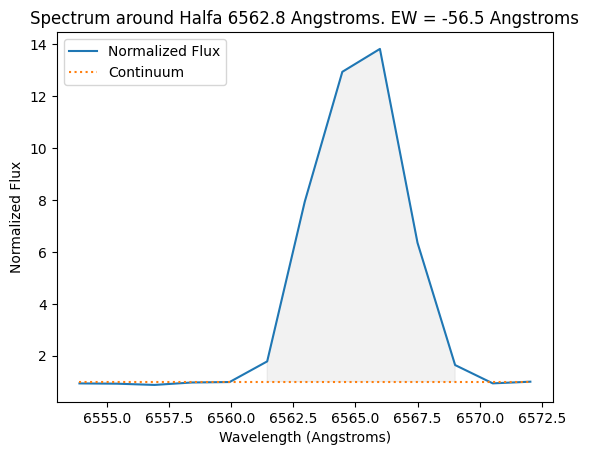

In [32]:
EW_fits_file("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp06-029.fits","Halfa",6562.8)

In [33]:
path = "..\\Catalogos\\vizier\\C-CW-W\\Classic\\fits\\"
#file_path = (f"{path}{file}")
#read_header_fits(file_path)
data_dir(path)

In [34]:
file = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp06-029.fits"

In [35]:
keyword_header_fits(file,"RA")

83.439395

In [36]:
keyword_header_fits(file,"DEC")

-5.60899

In [37]:
keyword_header_fits(file,"OBSID")

181106029

In [38]:
process_fits_file2(file,"Litio",6707)


-0.6

In [39]:
process_fits_file2(file,"H-alpha",6562.8)

-56.5

In [40]:
process_fits_file2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits2\\norm_spec-56617-VB081S05V1_sp04-134.fits","Litio",6707)

0.3

In [41]:
process_fits_file2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits2\\norm_spec-56617-VB081S05V1_sp04-134.fits","Halpha",6562.8)

-2.0

181104134
1


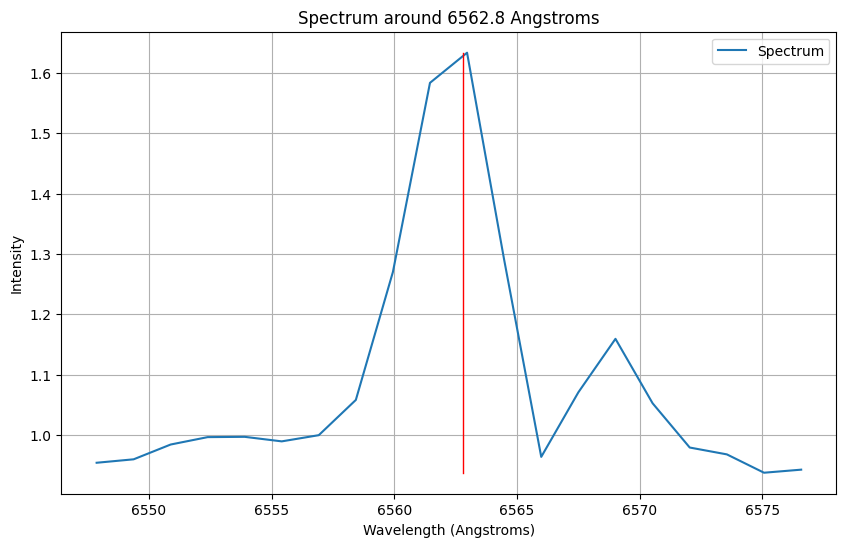

In [42]:
# Ejemplo de uso
#file = "spec-55960-GAC_101N09_V2_sp03-078.fits"
#file = "spec-55960-GAC_101N09_V2_sp03-079.fits"

file = "norm_spec-56617-VB081S05V1_sp04-134.fits"
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits2\\"

print(keyword_header_fits("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits2\\norm_spec-56617-VB081S05V1_sp04-134.fits","OBSID"))

fits_file = f"{path}{file}"
header,wavelength,intensity=read_spectrum_fits(fits_file)

central_wavelength = 6562.8  # Ejemplo: 6563 Angstroms (H-alpha)
width = 20 # Ejemplo: 20 Angstroms

wavelengths,intensities =  extract_spectrum_area(wavelength,intensity,central_wavelength,width)
print(identify_spectral_lines(wavelengths, intensities, central_wavelength))
plot_spectrum_area(wavelengths,intensities,central_wavelength, width)

In [43]:
for linea in lineas_espectrales:
    central_wavelength = lineas_espectrales[linea]
    width = 20 # Ejemplo: 20 Angstroms
    #wavelengths,intensities =  extract_spectrum_area(wavelength,intensity,central_wavelength,width)
    #print(identify_spectral_lines(wavelengths, intensities, central_wavelength))
    ew = process_fits_file2(file_path,linea,central_wavelength)
    #plot_spectrum_area(wavelengths,intensities, central_wavelength, width)

In [44]:
process_fits_file2("..\\Catalogos\\vizier\\NGC2264\\fits2\\norm_spec-58815-HIP2507201_sp07-043.fits","Halpha",6562.8)

0.1

1


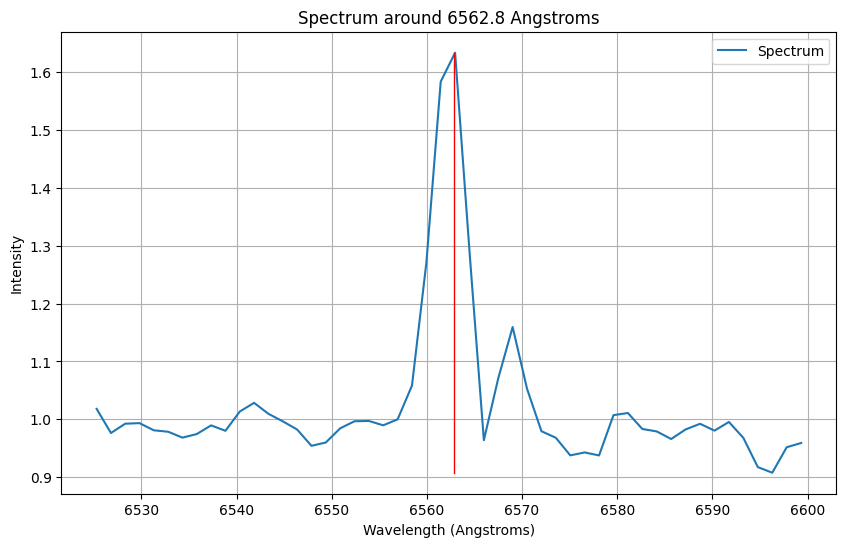

In [45]:
# Ejemplo de uso
#file = "spec-55960-GAC_101N09_V2_sp03-078.fits"
#file = "spec-55960-GAC_101N09_V2_sp03-079.fits"

#file = "spec-56617-VB081S05V1_sp15-208.fits"
#path = "..\\Catalogos\\vizier\\C-CW-W\\Classic\\fits\\"

#print(keyword_header_fits("..\\Catalogos\\vizier\\NGC2264\\fits2\\norm_spec-58815-HIP2507201_sp07-043.fits","OBSID"))

fits_file = f"{path}{file}"
header,wavelength,intensity=read_spectrum_fits(fits_file)

central_wavelength = 6562.8  # Ejemplo: 6563 Angstroms (H-alpha)
width = 50 # Ejemplo: 20 Angstroms

wavelengths,intensities =  extract_spectrum_area(wavelength,intensity,central_wavelength,width)
print(identify_spectral_lines(wavelengths, intensities, central_wavelength))
plot_spectrum_area(wavelengths,intensities,central_wavelength, width)

1


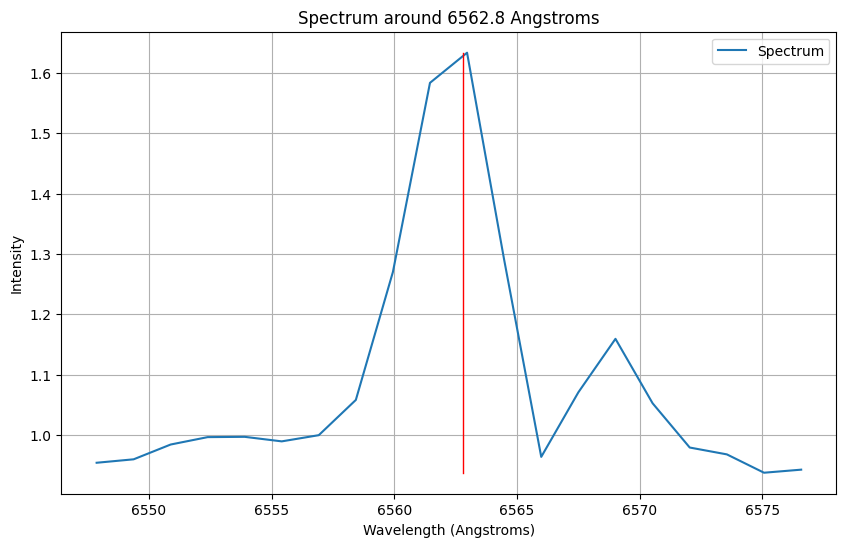

-1


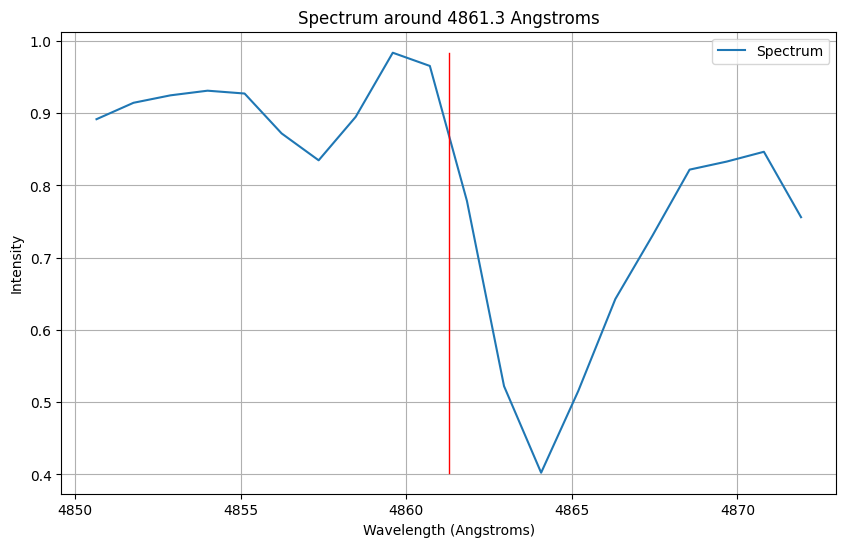

-1


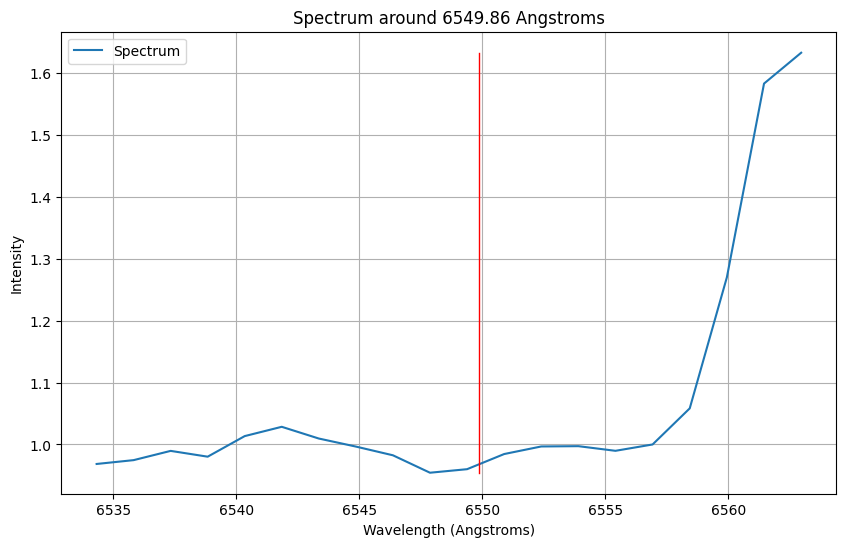

-1


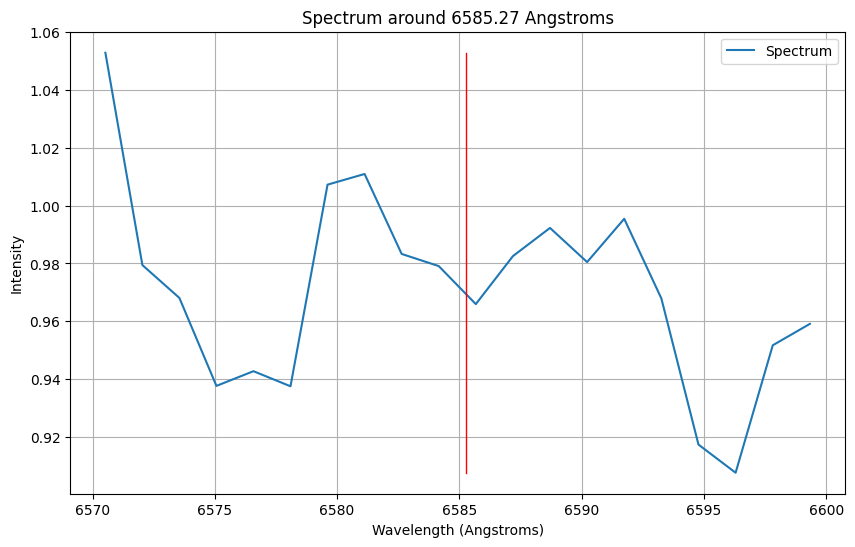

-1


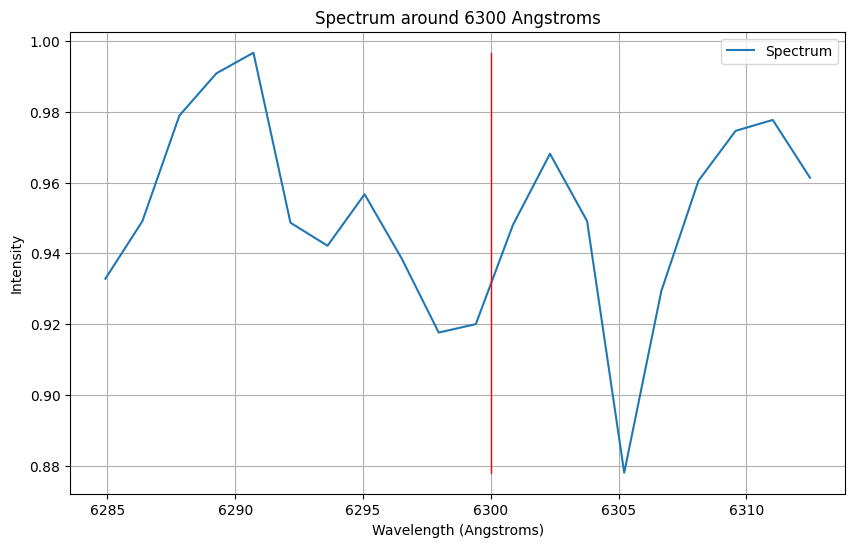

1


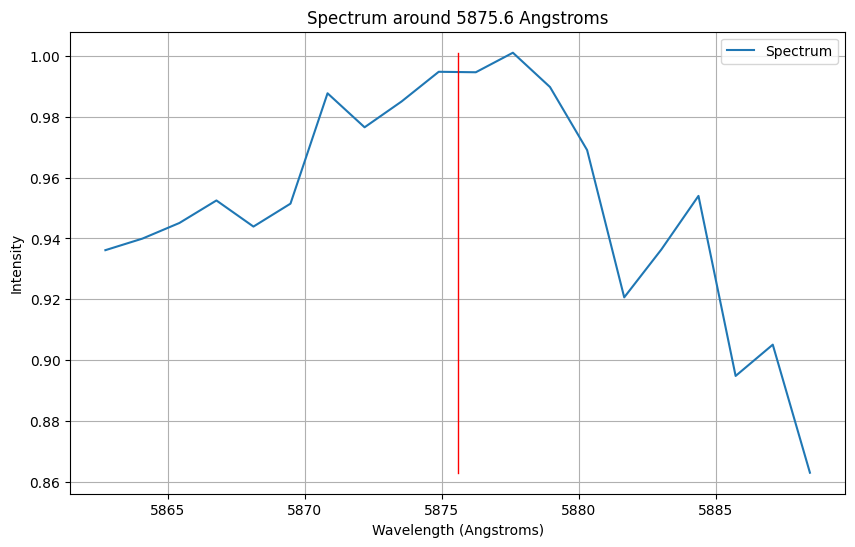

1


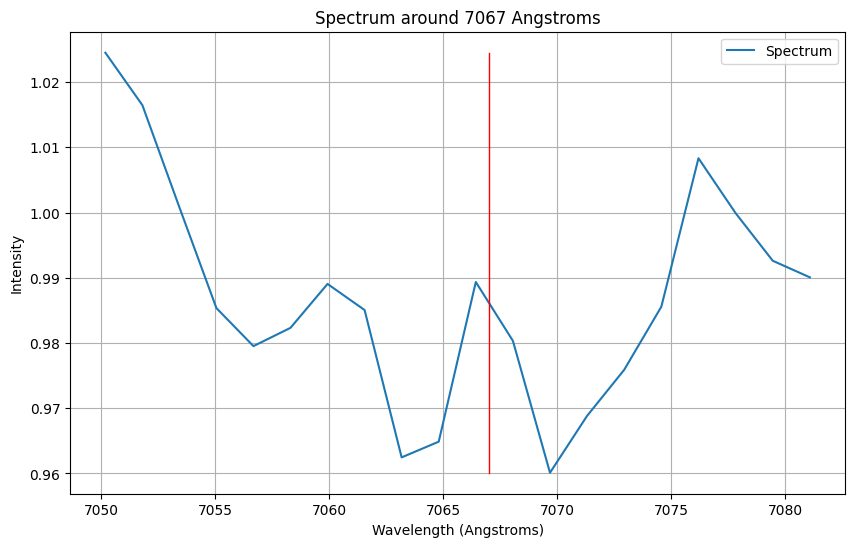

1


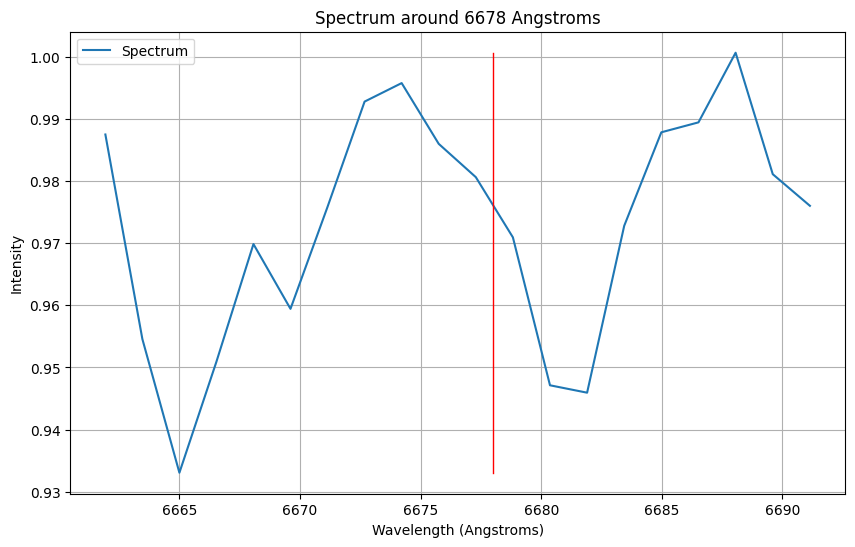

-1


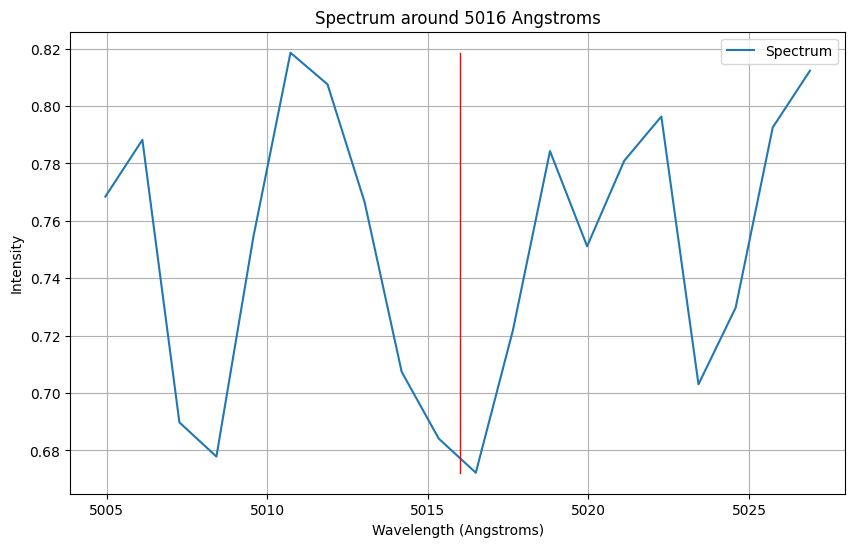

-1


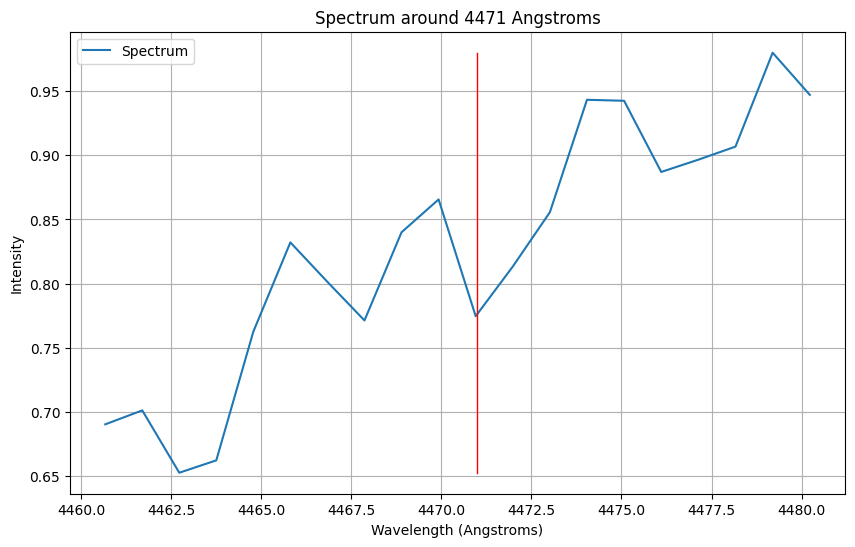

-1


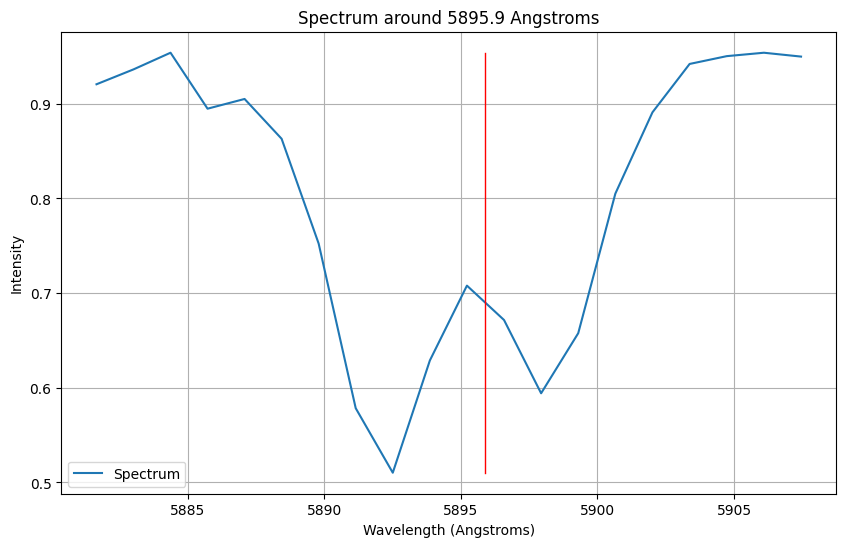

1


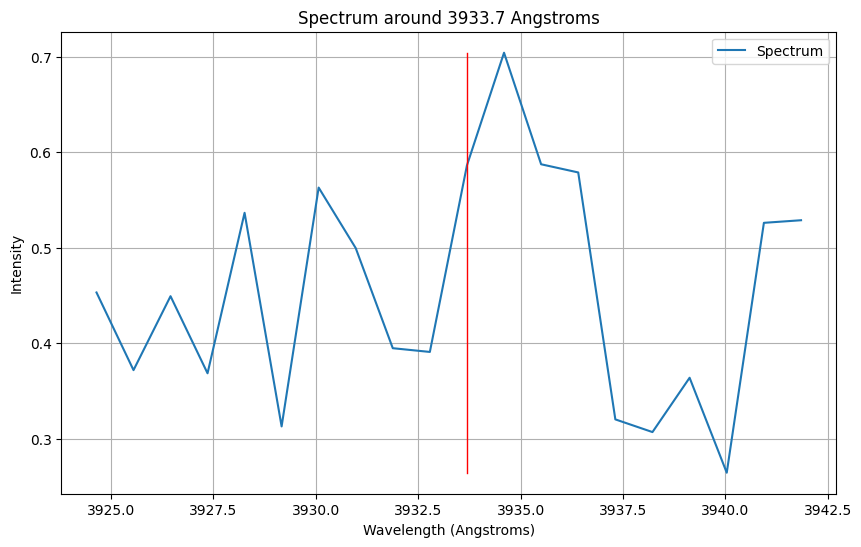

1


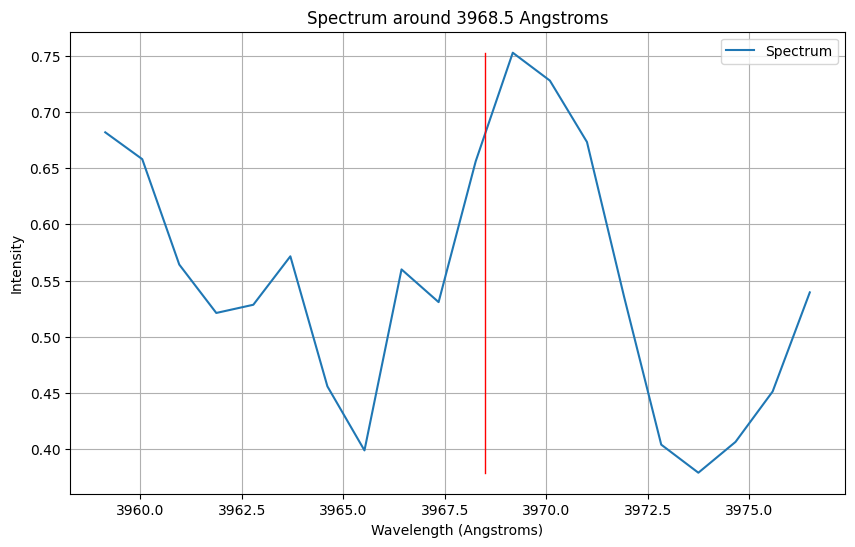

-1


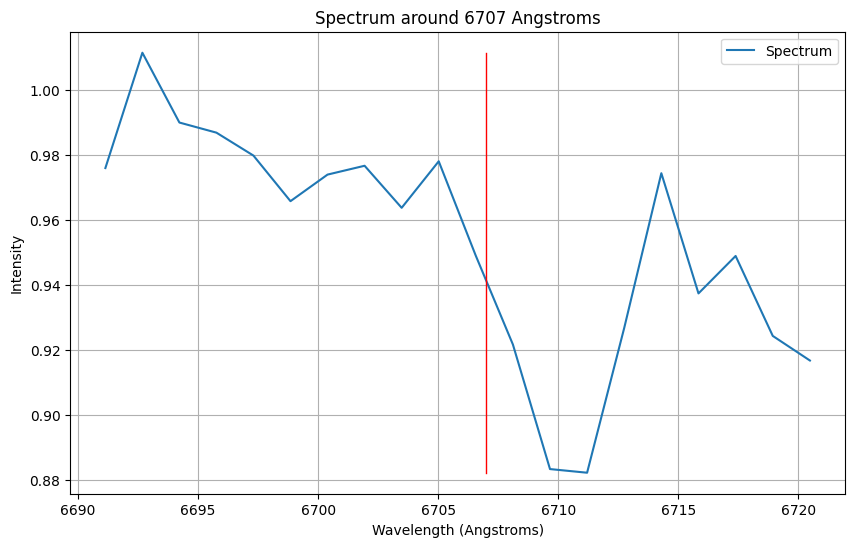

-1


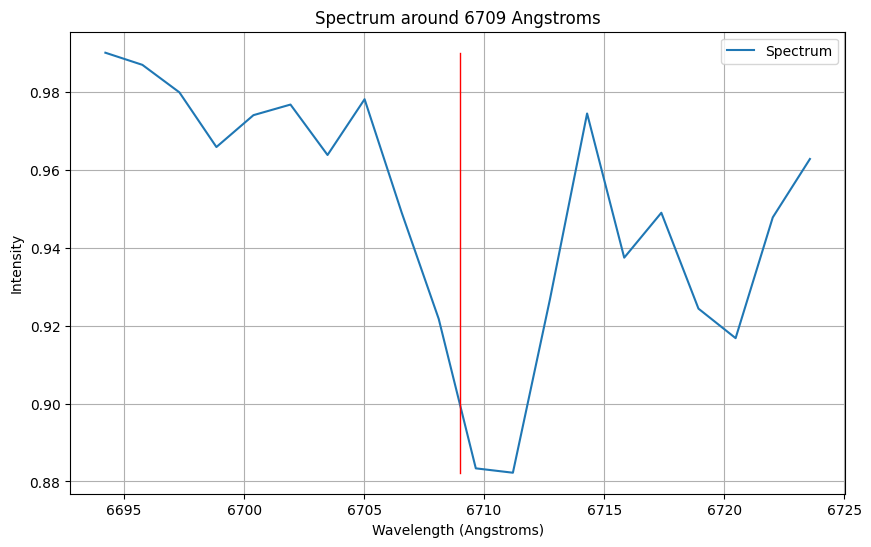

-1


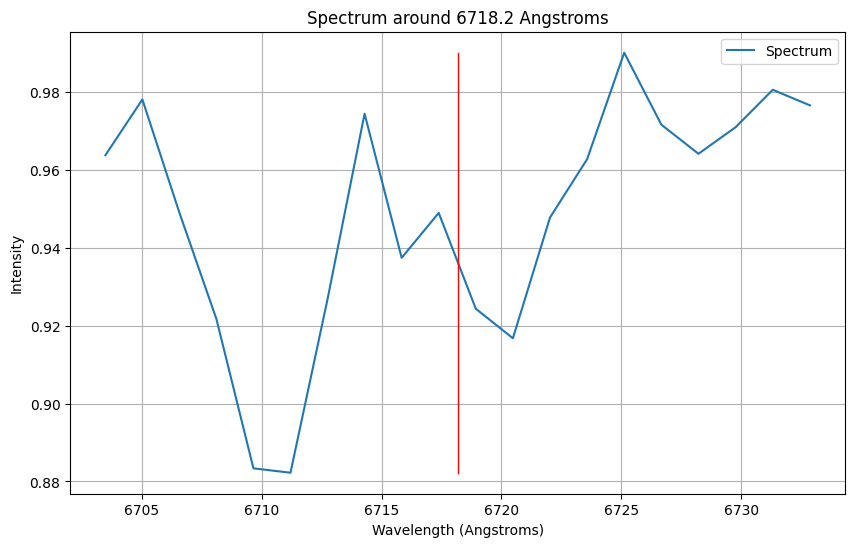

1


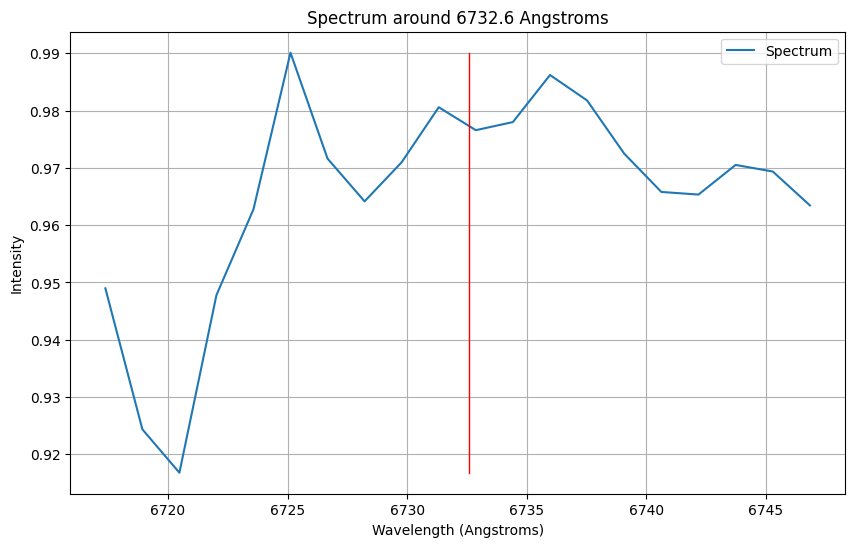

In [46]:
for linea in lineas_espectrales:
    central_wavelength = lineas_espectrales[linea]
    width = 20 # Ejemplo: 20 Angstroms
    wavelengths,intensities =  extract_spectrum_area(wavelength,intensity,central_wavelength,width)
    print(identify_spectral_lines(wavelengths, intensities, central_wavelength))
    plot_spectrum_area(wavelengths,intensities, central_wavelength, width)

In [47]:
#!pip install pandas
import os
import pandas as pd

def analysis_dir(path,clase,lines,width,fichero_variables):

# Extrae variables para un directorio que contiene ficheros fits
# Dado un path, clase (1: ttauri y 0: ttauri), fichero_variables donde se escribiran csv para entrenamiento
# 
# Escribe fichero_variables como csv con: 
#      Nombre de fichero fits
#      Clase (1 o 0)
#      Array con variables:
#      lineas de emisión 
    
# Comprobar si el directorio existe
    
    if not os.path.exists(path):
        print("El directorio especificado no existe.")
        return
    
    # Lista para almacenar los datos antes de convertirlos a DataFrame
    data = []
    
    # Recorrer los ficheros en el directorio
    for filename in os.listdir(path):
        #print(filename)
        if filename.endswith(".fits"):
             
            extracted_lines = extract_lines_spectrum (lines,f"{path}{filename}",width)
            #print(extracted_lines)
            #print(extracted_lines['Halfa'][0])
            #print(lines['Halfa'])

            file_lines = {label: identify_spectral_lines(extracted_lines[label][0],extracted_lines[label][1],lines[label]) for label in lines}
            
            #identify_spectral_lines(wavelengths, intensities, interest_wavelength)
            
            #total_frames, fps, tamaño_frame,duracion = obtener_metadatos(os.path.join(path, filename))
            
            # Llamar a tu función extraccion_variables_lote
            #variables = extraccion_variables(extraccion_deteccion(os.path.join(path, filename)))
            
            # Añadir al dataset
            data.append({
                "Nombre_Fichero": filename,
                "Clase": clase,
                "Array_Resultado": file_lines
            })

    # Convertir la lista de datos a DataFrame
    df = pd.DataFrame(data)
    
    # Guardar el DataFrame en un archivo CSV
    df.to_csv(f"{path}{fichero_variables}", index=False)

    print("El procesamiento ha finalizado y los resultados se han guardado en",path)
    
    return df




In [48]:
#!pip install pandas
import os
import pandas as pd

def extraccion_variables(filename,lines,width):

# Extrae variables para un fichero fits

# Devuelve un dataframe con: 
#      Nombre de fichero fits
#      Array con variables:
#      lineas de emisión 
    
    data = []
             
    extracted_lines = extract_lines_spectrum (lines,filename,width)
    #print(extracted_lines)
    #print(extracted_lines['Halfa'][0])
    #print(lines['Halfa'])

    file_lines = {label: identify_spectral_lines(extracted_lines[label][0],extracted_lines[label][1],lines[label]) for label in lines}
                    
    # Añadir al dataset
    data.append({
                "Nombre_Fichero": filename,
                "Array_Resultado": file_lines
    })

    # Convertir la lista de datos a DataFrame
    df = pd.DataFrame(data)
    
    return df


In [49]:
lines = lineas_espectrales

In [50]:
extraccion_variables("..\\Catalogos\\vizier\\ttauris\\norm_spec-55931-GAC_063N29_B1_sp16-153.fits",lines,20)

,Nombre_Fichero,Array_Resultado
0,..\Catalogos\vizier\ttauris\norm_spec-55931-GA...,"{'Halfa': -1, 'Hbeta': -1, 'NII': -1, 'NIIb': ..."


In [51]:
# saltar!!!!

## Demo extracción de variables

path = "..\\Catalogos\\vizier\\notttauris\\"
lines = lineas_espectrales
width = 20
fichero_variables = "classnotTTAURI.csv"
analysis_dir(path,"0",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\ttauris\\"
fichero_variables = "classTTAURI.csv"
analysis_dir(path,"1",lines,width,fichero_variables)



In [52]:
#crea dataset para entrenamiento desde un fichero csv: file

import ast
def crear_dataset (file):

    ttauris = pd.read_csv(file, sep = ',') # carga del CSV, usando como separador , 'comas'
    
    ttauris['Array_Resultado'] = ttauris['Array_Resultado'].apply(ast.literal_eval)
   
    ttauris = ttauris.join(pd.json_normalize(ttauris['Array_Resultado'])).drop(columns=['Array_Resultado'])
    
    #bolidos['R2'] = bolidos['R2'].astype(float)
    
    #bolidos['R2'] = pd.to_numeric(bolidos['R2'], errors='coerce')

    return ttauris

In [53]:
def safe_literal_eval(val):
    # Solo intentar evaluar si el valor es una cadena
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return val  # Devolver el valor original si hay un error
    else:
        # Si no es una cadena, devolver el valor tal como está (puede ser float, int, etc.)
        return val

In [54]:
#crea dataset para entrenamiento desde un fichero csv: file

import ast
def crear_dataset2 (file):

    ttauris = pd.read_csv(file, sep = ',') # carga del CSV, usando como separador , 'comas'
    
    ttauris['Array_Resultado'] = ttauris['Array_Resultado'].apply(safe_literal_eval)
   
    ttauris = ttauris.join(pd.json_normalize(ttauris['Array_Resultado'])).drop(columns=['Array_Resultado'])
    
    

    return ttauris

In [55]:
#df_ttauri = pd.concat([crear_dataset("..\\Catalogos\\notTTAURIv1\\classnotTTAURI.csv"),crear_dataset("..\\Catalogos\\TTAURIv1\\classTTAURI.csv")])

In [56]:
#df_ttauri

In [57]:
# Codigo Entrenamiento


df_ttauri = pd.concat([crear_dataset("..\\Catalogos\\vizier\\notttauris\\classnotTTAURI.csv"),crear_dataset("..\\Catalogos\\vizier\\ttauris\\classTTAURI.csv")])
df_ttauri = df_ttauri.sample(frac=1).reset_index(drop=True)

In [58]:
df_ttauri

,Nombre_Fichero,Clase,Halfa,Hbeta,NII,NIIb,OI,He I,He I b,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b,SII,SIIb
0,norm_spec-56617-VB081S05V2_sp13-063.fits,1,1,1,1,1,-1,1,1,1,-1,-1,-1,-1,1,-1,-1,1,1
1,norm_spec-55960-GAC_101N09_V1_sp14-066.fits,0,-1,-1,1,1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,1
2,norm_spec-57083-HD053813S011009V01_sp10-052.fits,1,-1,-1,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,-1,-1,1
3,norm_spec-57051-HD053443N053939V01_sp01-207.fits,1,-1,-1,1,-1,1,1,1,1,1,-1,1,-1,-1,-1,1,-1,1
4,norm_spec-57019-HD041823N213445V01_sp05-234.fits,1,-1,-1,1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,norm_spec-57827-HD054643N024226V01_sp10-071.fits,1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,-1,1,-1,-1,1
1464,norm_spec-55859-F5907_sp01-179.fits,0,-1,-1,1,1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,1,1,-1
1465,norm_spec-55859-M5901_sp03-163.fits,0,-1,1,-1,-1,-1,1,-1,1,-1,1,1,-1,-1,1,1,1,-1
1466,norm_spec-56617-VB081S05V1_sp11-068.fits,1,1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,-1,-1,1


In [59]:
# Se separan en df_X y df_Y para los dataset de entrenamiento

df_X = df_ttauri [['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']]
df_Y = df_ttauri [['Clase']]

# Separamos en train/test
from sklearn.model_selection import train_test_split

# Utilizamos una proporción 70/30. El parámetro random_state lo utilizamos para obtener los mismos resultados siempre
X_ttauri_train, X_ttauri_test, y_ttauri_train, y_ttauri_test = train_test_split(df_X, df_Y,test_size = 0.3, random_state = 42)

print("Dimensiones de conjuntos de entrenamiento: variables de entrada (X) y salida (y)", X_ttauri_train.shape, y_ttauri_train.shape)
print("Dimensiones de conjuntos de validación: variables de entrada (X) y salida (y)",X_ttauri_test.shape, y_ttauri_test.shape)



Dimensiones de conjuntos de entrenamiento: variables de entrada (X) y salida (y) (1027, 13) (1027, 1)
Dimensiones de conjuntos de validación: variables de entrada (X) y salida (y) (441, 13) (441, 1)


In [60]:
A=pd.DataFrame(X_ttauri_train[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']])

In [61]:
X_ttauri_train[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']]

,Halfa,Hbeta,OI,He I,He I b,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b
1395,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1
135,1,1,-1,1,-1,1,-1,-1,-1,1,1,1,-1
820,-1,-1,1,1,-1,1,-1,-1,-1,-1,-1,-1,1
477,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,1
1067,1,-1,1,1,1,-1,-1,1,1,1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,-1,-1,1,1,-1,1,-1,-1,-1,-1,-1,-1,1
1294,-1,-1,-1,1,-1,1,1,-1,-1,-1,-1,-1,1
860,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1
1459,1,-1,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1


In [62]:
X_ttauri_test[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']]

,Halfa,Hbeta,OI,He I,He I b,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b
1192,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,1,1
184,-1,-1,-1,1,-1,-1,1,-1,1,-1,-1,-1,1
1220,1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1
67,1,1,-1,1,-1,1,-1,-1,-1,1,1,-1,-1
220,1,1,-1,1,1,1,-1,1,-1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,1,1,-1,1,-1,1,-1,-1,-1,1,1,1,-1
331,-1,-1,-1,1,1,1,-1,-1,-1,-1,-1,-1,-1
323,-1,-1,-1,-1,1,1,-1,-1,1,-1,1,1,1
1125,1,1,-1,1,-1,1,-1,-1,-1,1,1,1,-1


Entrenamiento de módelos
Se van a entrenar varios modelos de Clasificación:

* Regresión Logística
* Árbol de Decisión
* KNN
* SVC
* Redes Neuronales

Y se obtendrán las métricas de recall, precisión y matriz de confusión para analizar su rendimiento

# Regresión Logística

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Creamos el objeto del modelo,fijando la semilla para evitar aleatoriedad. Se sube el parametro max_iter para que finalice
logreg = LogisticRegression(random_state=42,max_iter=10000)

# Entrenamos con el conjunto de train y su target
#X_ttauri_train = X_ttauri_train.select_dtypes(include = 'number')
#X_ttauri_test = X_ttauri_test.select_dtypes(include = 'number')

#logreg.fit(X_ttauri_train, y_ttauri_train['Clase'].values.ravel())
logreg.fit(X_ttauri_train[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']],y_ttauri_train)
logreg.coef_.shape

(1, 13)

In [64]:
print('Accuracy en train: ', logreg.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ', logreg.score(X_ttauri_test, y_ttauri_test[['Clase']]))

# Calculamos las métricas globales, con el parámetro average

preds_proy = logreg.predict(X_ttauri_test)
probs_proy = logreg.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

Accuracy en train:  0.8919182083739046
Accuracy en test:  0.891156462585034
Precision: 0.891
Recall 0.891
[[210  18]
 [ 30 183]]


# Árbol de decisión

In [65]:
from sklearn.tree import DecisionTreeClassifier

# Inicialiamos con sus parámetros por defecto (salvo la semilla)
tree_class = DecisionTreeClassifier(random_state = 42)

# Entrenamiento
tree_class.fit(X_ttauri_train, y_ttauri_train[['Clase']])
print('Accuracy en train: ',tree_class.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ', tree_class.score(X_ttauri_test, y_ttauri_test[['Clase']]))

# Calculamos las métricas globales, con el parámetro average

preds_proy = tree_class.predict(X_ttauri_test)
probs_proy = tree_class.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

Accuracy en train:  0.9337877312560857
Accuracy en test:  0.8616780045351474
Precision: 0.862
Recall 0.862
[[205  23]
 [ 38 175]]


# KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier

# Por defecto, k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())
print('Accuracy en train: ',knn.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',knn.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = knn.predict(X_ttauri_test)
probs_proy = knn.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

Accuracy en train:  0.9016553067185978
Accuracy en test:  0.8752834467120182
Precision: 0.875
Recall 0.875
[[174  31]
 [ 24 212]]


# SVC

In [74]:
from sklearn.svm import SVC

svc = SVC(random_state=42,probability=True) # parámetros por defecto

svc.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())
print('Accuracy en train: ',svc.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',svc.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = svc.predict(X_ttauri_test)
probs_proy = svc.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

Accuracy en train:  0.9094449853943525
Accuracy en test:  0.8979591836734694
Precision: 0.898
Recall 0.898
[[184  21]
 [ 24 212]]


# MLP

In [75]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state = 42,max_iter=1500)

mlp.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())

print('Accuracy en train: ',mlp.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',mlp.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = mlp.predict(X_ttauri_test)
probs_proy = mlp.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

Accuracy en train:  0.9308666017526777
Accuracy en test:  0.891156462585034
Precision: 0.891
Recall 0.891
[[178  27]
 [ 21 215]]


# Combinando modelos

In [76]:
from sklearn.ensemble import VotingClassifier

# Combinamos los 3 modelos anteriores (excluyendo a Vector Soporte por ser el peor)
vc = VotingClassifier(estimators = [('mlp',mlp),('logreg',logreg),('tree_class',tree_class),('svc',svc),('knn',knn)])
                      
# ojo con train no con test

vc.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print('Accuracy modelo combinado: %.3f' % vc.score(X_ttauri_test, y_ttauri_test))

Accuracy modelo combinado: 0.889


# Optimización de Hiperparámetros

In [77]:
from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda y posibles valores
grid_parameters = {'kernel': ['linear', 'rbf', 'poly'], 'C': [10.0, 1.0, 0.1, 0.01, 0.001]}

# Grid search
grid_SVC = GridSearchCV(SVC(random_state=42), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_SVC.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_SVC.best_params_)

print(grid_SVC.best_score_)

print(grid_SVC.best_estimator_)

{'C': 0.1, 'kernel': 'poly'}
0.8792445967526527
SVC(C=0.1, kernel='poly', random_state=42)


In [78]:
from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda y posibles valores
grid_parameters = {'hidden_layer_sizes': [(20,), (30,), (15, 15)], 
                   'activation': ['tanh', 'relu'] }

# Grid search
grid_MLP = GridSearchCV(MLPClassifier(random_state=42,max_iter=1500), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_MLP.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_MLP.best_params_)

print(grid_MLP.best_score_)

print(grid_MLP.best_estimator_)

{'activation': 'relu', 'hidden_layer_sizes': (20,)}
0.8782727794543047
MLPClassifier(hidden_layer_sizes=(20,), max_iter=1500, random_state=42)


In [79]:
from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda y posibles valores
grid_parameters = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'],'max_depth' : [1,2,3,4,5,6,7,8] }

# Grid search
grid_Tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_Tree.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_Tree.best_params_)

print(grid_Tree.best_score_)

print(grid_Tree.best_estimator_)

{'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}
0.8704783500701868
DecisionTreeClassifier(max_depth=5, random_state=42, splitter='random')


In [80]:
from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda y posibles valores
k_range = list(range(1, 31))
grid_parameters = dict(n_neighbors=k_range)

# Grid search
grid_KNN = GridSearchCV(KNeighborsClassifier(),param_grid = grid_parameters, cv = 10, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_KNN.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_KNN.best_params_)

print(grid_KNN.best_score_)

print(grid_KNN.best_estimator_)

{'n_neighbors': 14}
0.882172092137826
KNeighborsClassifier(n_neighbors=14)


In [81]:
c = VotingClassifier(estimators = [('mlp',grid_MLP),('logreg',logreg),('tree_class',grid_Tree),('svc',grid_SVC),('knn',grid_KNN)])
                      
# ojo con train no con test

vc.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print('Accuracy modelo combinado: %.3f' % vc.score(X_ttauri_test, y_ttauri_test))

Accuracy modelo combinado: 0.889


# Guardamos modelo

In [68]:
# Se almacena el modelo vc
from joblib import dump
import joblib  

#dump(vc, 'modelo_combinado_final.joblib')

# Evaluación de espectros

In [69]:
path_espectros="..\\Catalogos\\vizier\\test\\"


In [70]:
modelo = joblib.load('modelo_combinado_final.joblib')

In [71]:
star = extraccion_variables("..\\Catalogos\\vizier\\ttauris\\norm_spec-55931-GAC_063N29_B1_sp16-153.fits",lines,20)

In [72]:
star

,Nombre_Fichero,Array_Resultado
0,..\Catalogos\vizier\ttauris\norm_spec-55931-GA...,"{'Halfa': -1, 'Hbeta': -1, 'NII': -1, 'NIIb': ..."


In [73]:
#star['Array_Resultado'] = star['Array_Resultado'].apply(ast.literal_eval)

In [74]:
star = star.join(pd.json_normalize(star['Array_Resultado'])).drop(columns=['Array_Resultado'])

In [75]:
star

,Nombre_Fichero,Halfa,Hbeta,NII,NIIb,OI,He I,He I b,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b,SII,SIIb
0,..\Catalogos\vizier\ttauris\norm_spec-55931-GA...,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1


In [76]:
clasificacion = modelo.predict(star[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']])
print("La clasificacion es:",clasificacion[0])

La clasificacion es: 0


In [77]:
#y_ttauri_train['Clase']

In [78]:
def evalua_directorio(directorio):
    # Recorrer todos los archivos en el directorio especificado y los evalua según el modelo

    for filename in os.listdir(directorio):
        filepath = os.path.join(directorio, filename)
        
        if filepath.endswith('.fits'):
            try:
                # Utilizando 'with' para asegurar que el archivo se cierra correctamente
                with fits.open(filepath) as hdul:
                    if esta_normalizado(hdul):
                        new_filename = f"norm_{filename}"
                        new_filepath = os.path.join(directorio, new_filename)
                        # Copiar el archivo original al nuevo nombre
                        shutil.copy(filepath, new_filepath)
                        print(f"Archivo creado: {new_filename}")
            except Exception as e:
                print(f"No se pudo procesar el archivo {filename}: {e}")

directorio="..\\Catalogos\\vizier\\ttauris\\"
class0 = 0
class1 = 0
total = 0
for filename in os.listdir(directorio):
    filepath = os.path.join(directorio,filename)

    if filepath.endswith('.fits'):
            try:
                # Utilizando 'with' para asegurar que el archivo se cierra correctamente
                with fits.open(filepath) as hdul:
                    if esta_normalizado(hdul):
                        star = extraccion_variables(filepath,lines,20)
                        star = star.join(pd.json_normalize(star['Array_Resultado'])).drop(columns=['Array_Resultado'])
                        clase = modelo.predict(star[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']])
                        if clase == 0:
                            class0+=1
                            total+=1
                        elif clase == 1:
                            class1+=1
                            total+=1
                        else:
                            total+=1
                        #print(filepath," class: ",clasificacion)
            except Exception as e:
                print(f"No se pudo procesar el archivo {filename}: {e}")



print("total: ",total," ttauri: ", class1, " (",class1/total," %) ", "not ttauri: ",class0, " (",class0/total," %) ") 

directorio="..\\Catalogos\\vizier\\notttauris\\"
class0 = 0
class1 = 0
total = 0
for filename in os.listdir(directorio):
    filepath = os.path.join(directorio,filename)

    if filepath.endswith('.fits'):
            try:
                # Utilizando 'with' para asegurar que el archivo se cierra correctamente
                with fits.open(filepath) as hdul:
                    if esta_normalizado(hdul):
                        star = extraccion_variables(filepath,lines,20)
                        star = star.join(pd.json_normalize(star['Array_Resultado'])).drop(columns=['Array_Resultado'])
                        clase = modelo.predict(star[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']])
                        if clase == 0:
                            class0+=1
                            total+=1
                        elif clase == 1:
                            class1+=1
                            total+=1
                        else:
                            total+=1
                        #print(filepath," class: ",clasificacion)
            except Exception as e:
                print(f"No se pudo procesar el archivo {filename}: {e}")



print("total: ",total," ttauri: ", class1, " (",class1/total," %) ", "not ttauri: ",class0, " (",class0/total," %) ") 

## Entrenamiento Multiclase

#Extracción de variables
path = "..\\Catalogos\\vizier\\C-CW-W\\ND\\fits2\\"
lines = lineas_espectrales
width = 20
fichero_variables = "ND.csv"
analysis_dir(path,"0",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\C-CW-W\\Classic\\fits2\\"
fichero_variables = "Classic.csv"
analysis_dir(path,"1",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\C-CW-W\\ClassicWeak\\fits2\\"
fichero_variables = "ClassicWeak.csv"
analysis_dir(path,"2",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\C-CW-W\\Weak\\fits2\\"
fichero_variables = "Weak.csv"
analysis_dir(path,"3",lines,width,fichero_variables)

In [93]:
# Codigo Entrenamiento


df_ttauri = pd.concat([
                       crear_dataset("..\\Catalogos\\vizier\\C-CW-W\\ND\\fits2\\ND.csv"),
                       crear_dataset("..\\Catalogos\\vizier\\C-CW-W\\Classic\\fits2\\Classic.csv"),
                       crear_dataset("..\\Catalogos\\vizier\\C-CW-W\\ClassicWeak\\fits2\\ClassicWeak.csv"),
                       crear_dataset("..\\Catalogos\\vizier\\C-CW-W\\Weak\\fits2\\Weak.csv"),])
df_ttauri = df_ttauri.sample(frac=1).reset_index(drop=True)

In [94]:
print("Train")
print("clase 0: ND ",df_ttauri[df_ttauri['Clase']==0].shape)
print("clase 1: Classic ",df_ttauri[df_ttauri['Clase']==1].shape)
print("clase 2: ClassicWeak ",df_ttauri[df_ttauri['Clase']==2].shape)
print("clase 3: Weak ",df_ttauri[df_ttauri['Clase']==3].shape)

Train
clase 0: ND  (65, 15)
clase 1: Classic  (5, 15)
clase 2: ClassicWeak  (2, 15)
clase 3: Weak  (57, 15)


In [95]:
# Se separan en df_X y df_Y para los dataset de entrenamiento

df_X = df_ttauri [['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']]
df_Y = df_ttauri [['Clase']]

# Separamos en train/test
from sklearn.model_selection import train_test_split

# Utilizamos una proporción 70/30. El parámetro random_state lo utilizamos para obtener los mismos resultados siempre
X_ttauri_train, X_ttauri_test, y_ttauri_train, y_ttauri_test = train_test_split(df_X, df_Y,test_size = 0.3,stratify=df_Y, random_state = 42)

print("Dimensiones de conjuntos de entrenamiento: variables de entrada (X) y salida (y)", X_ttauri_train.shape, y_ttauri_train.shape)
print("Dimensiones de conjuntos de validación: variables de entrada (X) y salida (y)",X_ttauri_test.shape, y_ttauri_test.shape)

Dimensiones de conjuntos de entrenamiento: variables de entrada (X) y salida (y) (90, 13) (90, 1)
Dimensiones de conjuntos de validación: variables de entrada (X) y salida (y) (39, 13) (39, 1)


In [96]:
A=pd.DataFrame(X_ttauri_train[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']])

In [97]:
print("Train")
print("clase 0: ND ",y_ttauri_train[y_ttauri_train['Clase']==0].shape)
print("clase 1: Classic ",y_ttauri_train[y_ttauri_train['Clase']==1].shape)
print("clase 2: ClassicWeak ",y_ttauri_train[y_ttauri_train['Clase']==2].shape)
print("clase 3: Weak ",y_ttauri_train[y_ttauri_train['Clase']==3].shape)

Train
clase 0: ND  (45, 1)
clase 1: Classic  (4, 1)
clase 2: ClassicWeak  (1, 1)
clase 3: Weak  (40, 1)


In [98]:
print("Test")
print("clase 0: ND ",y_ttauri_test[y_ttauri_test['Clase']==0].shape)
print("clase 1: Classic ",y_ttauri_test[y_ttauri_test['Clase']==1].shape)
print("clase 2: ClassicWeak ",y_ttauri_test[y_ttauri_test['Clase']==2].shape)
print("clase 3: Weak ",y_ttauri_test[y_ttauri_test['Clase']==3].shape)

Test
clase 0: ND  (20, 1)
clase 1: Classic  (1, 1)
clase 2: ClassicWeak  (1, 1)
clase 3: Weak  (17, 1)


In [99]:
X_ttauri_train[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']]

,Halfa,Hbeta,OI,He I,He I b,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b
75,1,-1,-1,1,-1,-1,-1,1,-1,1,1,-1,-1
42,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
57,0,0,0,0,0,0,0,0,0,0,0,0,0
31,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,1
65,1,1,-1,1,-1,1,-1,1,-1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,1
40,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1
48,1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1
10,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1


## Regresión Logistica

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Creamos el objeto del modelo,fijando la semilla para evitar aleatoriedad. Se sube el parametro max_iter para que finalice
logreg = LogisticRegression(random_state=42,max_iter=10000)

# Entrenamos con el conjunto de train y su target
#X_ttauri_train = X_ttauri_train.select_dtypes(include = 'number')
#X_ttauri_test = X_ttauri_test.select_dtypes(include = 'number')

#logreg.fit(X_ttauri_train, y_ttauri_train['Clase'].values.ravel())
logreg.fit(X_ttauri_train[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']],y_ttauri_train)
logreg.coef_.shape

(4, 13)

Accuracy en train:  0.9444444444444444
Accuracy en test:  0.8974358974358975
Precision: 0.897
Recall 0.897
[[18  0  0  2]
 [ 0  1  0  0]
 [ 0  0  0  1]
 [ 0  1  0 16]]


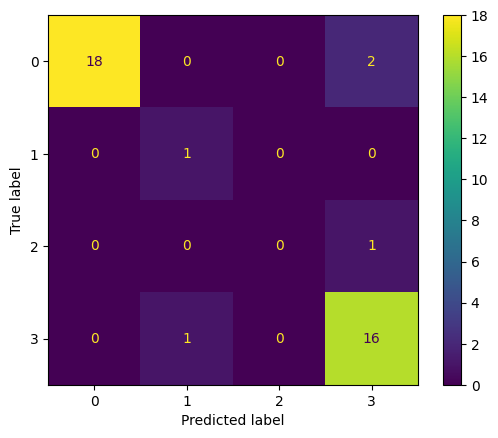

In [101]:
print('Accuracy en train: ', logreg.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ', logreg.score(X_ttauri_test, y_ttauri_test[['Clase']]))

# Calculamos las métricas globales, con el parámetro average

preds_proy = logreg.predict(X_ttauri_test)
probs_proy = logreg.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg.classes_)
disp.plot()

plt.show()

## Árbol de decisión

Accuracy en train:  0.9666666666666667
Accuracy en test:  0.8717948717948718
Precision: 0.872
Recall 0.872
[[20  0  0  0]
 [ 0  0  0  1]
 [ 0  0  0  1]
 [ 2  0  1 14]]


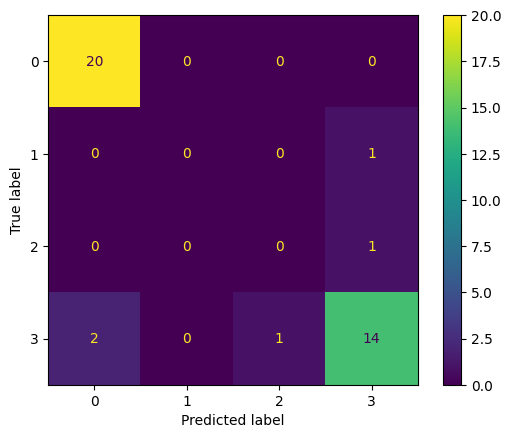

In [102]:
from sklearn.tree import DecisionTreeClassifier

# Inicialiamos con sus parámetros por defecto (salvo la semilla)
tree_class = DecisionTreeClassifier(random_state = 42)

# Entrenamiento
tree_class.fit(X_ttauri_train, y_ttauri_train[['Clase']])
print('Accuracy en train: ',tree_class.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ', tree_class.score(X_ttauri_test, y_ttauri_test[['Clase']]))

# Calculamos las métricas globales, con el parámetro average

preds_proy = tree_class.predict(X_ttauri_test)
probs_proy = tree_class.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=tree_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=tree_class.classes_)
disp.plot()

plt.show()

## KNN

Accuracy en train:  0.8777777777777778
Accuracy en test:  0.9230769230769231
Precision: 0.923
Recall 0.923
[[19  0  0  1]
 [ 0  0  0  1]
 [ 0  0  0  1]
 [ 0  0  0 17]]


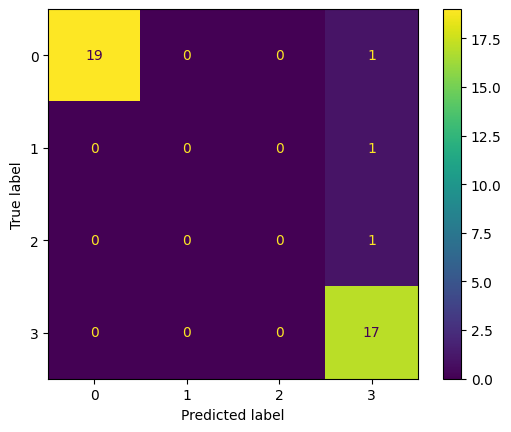

In [103]:
from sklearn.neighbors import KNeighborsClassifier

# Por defecto, k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())
print('Accuracy en train: ',knn.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',knn.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = knn.predict(X_ttauri_test)
probs_proy = knn.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn.classes_)
disp.plot()

plt.show()


## SVC

Accuracy en train:  0.9333333333333333
Accuracy en test:  0.9487179487179487
Precision: 0.949
Recall 0.949
[[20  0  0  0]
 [ 0  0  0  1]
 [ 0  0  0  1]
 [ 0  0  0 17]]


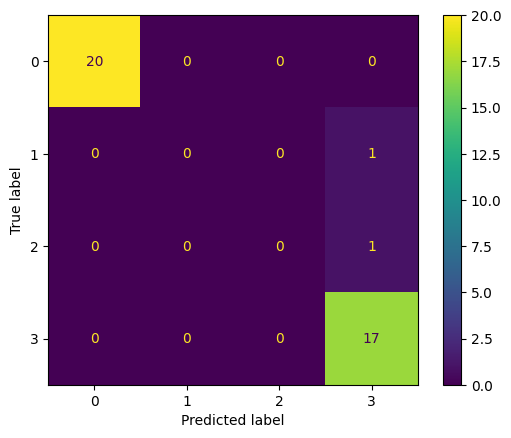

In [104]:
from sklearn.svm import SVC

svc = SVC(random_state=42,probability=True) # parámetros por defecto

svc.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())
print('Accuracy en train: ',svc.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',svc.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = svc.predict(X_ttauri_test)
probs_proy = svc.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc.classes_)
disp.plot()

plt.show()


## MLP

Accuracy en train:  0.9666666666666667
Accuracy en test:  0.9230769230769231
Precision: 0.923
Recall 0.923
[[20  0  0  0]
 [ 0  1  0  0]
 [ 0  0  0  1]
 [ 0  2  0 15]]


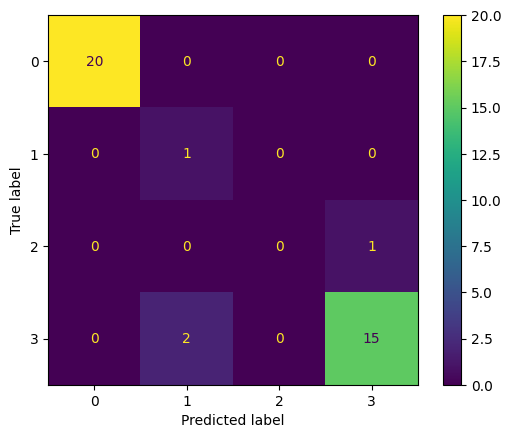

In [105]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state = 42,max_iter=1500)

mlp.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())

print('Accuracy en train: ',mlp.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',mlp.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = mlp.predict(X_ttauri_test)
probs_proy = mlp.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=mlp.classes_)
disp.plot()

plt.show()

## Combinando modelos

Accuracy modelo combinado: 0.923


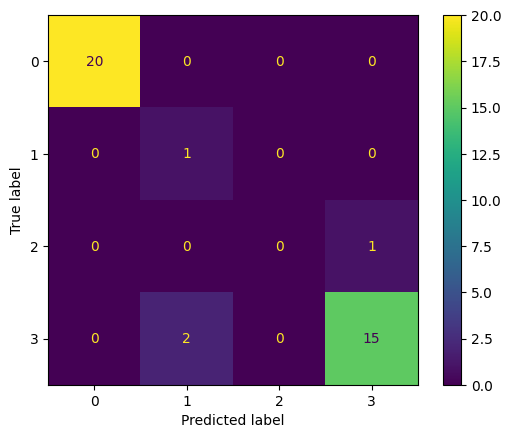

In [106]:
from sklearn.ensemble import VotingClassifier

# Combinamos los 3 modelos anteriores (excluyendo a Vector Soporte por ser el peor)
vc = VotingClassifier(estimators = [('mlp',mlp),('logreg',logreg),('tree_class',tree_class),('svc',svc),('knn',knn)])
                      
# ojo con train no con test

vc.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print('Accuracy modelo combinado: %.3f' % vc.score(X_ttauri_test, y_ttauri_test))

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=vc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=vc.classes_)
disp.plot()

plt.show()


## Optimización de Hiperparámetros

In [107]:
from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda y posibles valores
grid_parameters = {'kernel': ['linear', 'rbf', 'poly'], 'C': [10.0, 1.0, 0.1, 0.01, 0.001]}

# Grid search
grid_SVC = GridSearchCV(SVC(random_state=42), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_SVC.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_SVC.best_params_)

print(grid_SVC.best_score_)

print(grid_SVC.best_estimator_)
{'C': 0.1, 'kernel': 'poly'}

from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda y posibles valores
grid_parameters = {'hidden_layer_sizes': [(20,), (30,), (15, 15)], 
                   'activation': ['tanh', 'relu'] }

# Grid search
grid_MLP = GridSearchCV(MLPClassifier(random_state=42,max_iter=1500), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_MLP.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_MLP.best_params_)

print(grid_MLP.best_score_)

print(grid_MLP.best_estimator_)

MLPClassifier(hidden_layer_sizes=(20,), max_iter=1500, random_state=42)
from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda y posibles valores
grid_parameters = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'],'max_depth' : [1,2,3,4,5,6,7,8] }

# Grid search
grid_Tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_Tree.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_Tree.best_params_)

print(grid_Tree.best_score_)

print(grid_Tree.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42,
                       splitter='random')
from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda y posibles valores
k_range = list(range(1, 31))
grid_parameters = dict(n_neighbors=k_range)

# Grid search
grid_KNN = GridSearchCV(KNeighborsClassifier(),param_grid = grid_parameters, cv = 10, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_KNN.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_KNN.best_params_)

print(grid_KNN.best_score_)

print(grid_KNN.best_estimator_)

KNeighborsClassifier(n_neighbors=20)
c = VotingClassifier(estimators = [('mlp',grid_MLP),('logreg',logreg),('tree_class',grid_Tree),('svc',grid_SVC),('knn',grid_KNN)])
                      
# ojo con train no con test

vc.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print('Accuracy modelo combinado: %.3f' % vc.score(X_ttauri_test, y_ttauri_test))

# Se almacena el modelo vc
from joblib import dump
import joblib  

dump(vc, 'modelo_combinado_final.joblib')


{'C': 0.1, 'kernel': 'linear'}
0.888888888888889
SVC(C=0.1, kernel='linear', random_state=42)
{'activation': 'relu', 'hidden_layer_sizes': (15, 15)}
0.9
MLPClassifier(hidden_layer_sizes=(15, 15), max_iter=1500, random_state=42)
{'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
0.8555555555555556
DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42,
                       splitter='random')
{'n_neighbors': 11}
0.9111111111111112
KNeighborsClassifier(n_neighbors=11)
Accuracy modelo combinado: 0.923


['modelo_combinado_final.joblib']

## 2mass

In [79]:
#!pip install astroquery

In [80]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u
import math

def obtener_magnitudes_2mass(ra, dec):
    # Crear coordenadas del objeto
    coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    
    # Configurar Vizier para buscar en el catálogo 2MASS
    vizier = Vizier(columns=['RAJ2000', 'DEJ2000', 'Jmag', 'Hmag', 'Kmag'])
    vizier.ROW_LIMIT = 1  # Limitar a una fila
    
    # Realizar la consulta
    result = vizier.query_region(coords, radius=5*u.arcsec, catalog='II/246')
    
    if len(result) == 0:
        print("No se encontraron estrellas en 2MASS para las coordenadas dadas.")
        return math.nan,math.nan,math.nan
    
    # Obtener los datos de magnitudes
    star_data = result[0]
    j_mag = star_data['Jmag'][0]
    h_mag = star_data['Hmag'][0]
    k_mag = star_data['Kmag'][0]
    
    return j_mag, h_mag, k_mag

# Ejemplo de uso
ra = 100.17236   # Ascensión recta en grados
dec =  9.903835 # Declinación en grados

magnitudes = obtener_magnitudes_2mass(ra, dec)

if magnitudes:
    j_mag, h_mag, k_mag = magnitudes
    print(f"Magnitudes J: {j_mag}, H: {h_mag}, K: {k_mag}")

Magnitudes J: 11.640000343322754, H: 10.951000213623047, K: 10.427000045776367


from astroquery.ukidss import Ukidss
from astropy.coordinates import SkyCoord
import astropy.units as u

def obtener_magnitudes_ukidss(ra, dec, radius=1, programme_id='LAS'):
    """
    Consulta el catálogo UKIDSS para obtener las magnitudes J, H y K de una región dada por RA y Dec.

    Parameters:
    ra (float): Ascensión recta en grados.
    dec (float): Declinación en grados.
    radius (float): Radio de búsqueda en grados (default: 0.001 grados).
    programme_id (str): ID del programa UKIDSS (default: 'LAS', puedes cambiar según tu necesidad).

    Returns:
    result_filtered (Table): Una tabla con las coordenadas y magnitudes J, H y K, o un mensaje si no hay resultados.
    """
    # Crear un objeto SkyCoord para las coordenadas RA y Dec
    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    radius = radius * u.deg

    # Intentar realizar la consulta a UKIDSS
    try:
        result = Ukidss.query_region(coord, radius=radius, programme_id=programme_id)
        
        # Verificar si hay resultados
        if result is not None and len(result) > 0:
            # Tomar el primer objeto encontrado y extraer sus magnitudes J, H, K
            j_mag = result['jAperMag3'][0]
            h_mag = result['hAperMag3'][0]
            k_mag = result['kAperMag3'][0]
            return j_mag, h_mag, k_mag
        else:
            math.nan,math.nan,math.nan  # Si no se encuentran datos
    except Exception as e:
        print(f"Error en la consulta: {e}")
        math.nan,math.nan,math.nan

# Ejemplo de uso
ra_example = 10.684  # Ejemplo de RA (en grados)
dec_example = 41.269  # Ejemplo de Dec (en grados)
result = obtener_magnitude_ukidss(ra_example, dec_example, radius=0.005)

if isinstance(result, str):
    print(result)  # En caso de error o sin resultados
else:
    print(result)  # Resultados de la consulta


In [81]:
def obtenerJH_HK(file):
    ra,dec = radec_header_fits(file)
    #print (ra,dec)
    j,h,k =  obtener_magnitudes_2mass(ra, dec)
    #print ( j,h,k)
    return j-h,h-k

In [82]:
obtenerJH_HK("..\\Catalogos\\vizier\\NGC2264\\fits2\\norm_spec-58815-HIP2507201_sp07-043.fits")


(0.5450001, 0.1079998)

obtenerJH_HK2("..\\Catalogos\\vizier\\NGC2264\\fits2\\norm_spec-58815-HIP2507201_sp07-043.fits")

In [120]:
obtenerJH_HK("..\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\spec-55859-F5902_sp01-018.fits")

No se encontraron estrellas en 2MASS para las coordenadas dadas.


(nan, nan)

In [ ]:
keyword_header_fits("..\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\spec-55859-F5902_sp01-018.fits","RA")

In [ ]:
keyword_header_fits("..\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\spec-55859-F5902_sp01-018.fits","DEC")

In [ ]:
header, wavelength, intensity = read_spectrum_fits("..\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\spec-55859-F5902_sp01-018.fits")
print(header)
print(wavelength)
print(intensity)

In [ ]:
obtenerJH_HK("..\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp13-047.fits")

In [ ]:
obtenerJH_HK("..\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp04-134.fits")

## Gaia

In [ ]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

def obtener_datos_gaia(ra, dec):
    # Crear coordenadas del objeto
    coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')

    # Consulta al catálogo Gaia DR3 alrededor de las coordenadas dadas
    width = u.Quantity(5, u.arcsec)
    height = u.Quantity(5, u.arcsec)

    query = f"""
        SELECT TOP 1 * 
        FROM gaiadr3.gaia_source 
        WHERE CONTAINS(POINT('ICRS', gaiadr3.gaia_source.ra, gaiadr3.gaia_source.dec), 
                       CIRCLE('ICRS', {ra}, {dec}, 0.000138889))=1
    """
    
    job = Gaia.launch_job(query)
    result = job.get_results()

    if len(result) == 0:
        print("No se encontraron estrellas en Gaia DR3 para las coordenadas dadas.")
        return math.nan

    # Extraer los datos necesarios
    star_data = result[0]
    parallax = star_data['parallax']
    radial_velocity = star_data['radial_velocity']
    distance = 1000 / parallax if parallax > 0 else None  # Calcular la distancia en parsecs

    return parallax, radial_velocity, distance



In [ ]:
## Entrenamiento Multiclase Briceño / Hernandez / Serna

In [ ]:
##def identify_spectral_lines(wavelengths, intensities, interest_wavelength):
##def process_fits_file(file_path,name,wave):

In [ ]:
def extract_lines_spectrum2 (lines,file,width):
    
    header,wavelengths,intensities = read_spectrum_fits (file)
    file_lines = {label: extract_spectrum_area(wavelengths,intensities,lines[label],width) for label in lines}
    return file_lines

In [ ]:
import random

In [ ]:
import math

In [ ]:
#!pip install pandas
import os
import pandas as pd

def analysis_dir2(path,clase,lines,width,fichero_variables):

# Extrae variables para un directorio que contiene ficheros fits

# Comprobar si el directorio existe
    
    if not os.path.exists(path):
        print("El directorio especificado no existe.")
        return
    
    # Lista para almacenar los datos antes de convertirlos a DataFrame
    data = []
    
    # Recorrer los ficheros en el directorio
    for filename in os.listdir(path):
        #print(filename)
        if filename.endswith(".fits"):
             
            #extracted_lines = extract_lines_spectrum2 (lines,f"{path}{filename}",width)
            #print(extracted_lines)
            #print(extracted_lines['Halfa'][0])
            #print(lines['Halfa'])

            #file_lines = {label: identify_spectral_lines2(extracted_lines[label][0],extracted_lines[label][1],lines[label]) for label in lines}
            file_lines = {label: process_fits_file2(f"{path}{filename}",label,lines[label]) for label in lines}
            
            jh,hk = obtenerJH_HK(f"{path}{filename}")
            ra,dec = radec_header_fits(f"{path}{filename}")
            oid = keyword_header_fits(f"{path}{filename}","OBSID")
            
            #jh = random.uniform(-1.5, 1.5)
            #hk = random.uniform(-1.5, 1.5)
            #identify_spectral_lines(wavelengths, intensities, interest_wavelength)
            
            #total_frames, fps, tamaño_frame,duracion = obtener_metadatos(os.path.join(path, filename))
            
            # Llamar a tu función extraccion_variables_lote
            #variables = extraccion_variables(extraccion_deteccion(os.path.join(path, filename)))
            
            # Añadir al dataset
            data.append({
                "Nombre_Fichero": filename,
                "RA": ra,
                "DEC": dec,
                "OID": oid,
                "Clase": clase,
                "J_H": jh,
                "H_K": hk,
                "Array_Resultado": file_lines
            })

    # Convertir la lista de datos a DataFrame
    df = pd.DataFrame(data)
    
    # Guardar el DataFrame en un archivo CSV
    df.to_csv(f"{path}{fichero_variables}", index=False)

    print("El procesamiento ha finalizado y los resultados se han guardado en",path)
    
    return df




In [ ]:
#Extracción de variables 4 clases

#Extracción de variables
width = 20
lines = lineas_espectrales
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\"
fichero_variables = "Classic.csv"
analysis_dir2(path,"1",lines,width,fichero_variables)

#Extracción de variables
width = 20
lines = lineas_espectrales
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\"
fichero_variables = "MS.csv"
analysis_dir2(path,"4",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\"
fichero_variables = "Classic.csv"
analysis_dir2(path,"1",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\ClassicWeak\\fits\\"
fichero_variables = "ClassicWeak.csv"
analysis_dir2(path,"2",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Weak\\fits\\"
fichero_variables = "Weak.csv"
analysis_dir2(path,"3",lines,width,fichero_variables)

#Extracción de variables 2 clases

#Extracción de variables
width = 20
lines = lineas_espectrales
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\"
fichero_variables = "MS2.csv"
analysis_dir2(path,"2",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\"
fichero_variables = "Classic2.csv"
analysis_dir2(path,"1",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\ClassicWeak\\fits\\"
fichero_variables = "ClassicWeak2.csv"
analysis_dir2(path,"1",lines,width,fichero_variables)
path = "..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Weak\\fits\\"
fichero_variables = "Weak2.csv"
analysis_dir2(path,"1",lines,width,fichero_variables)

In [129]:
# Codigo Entrenamiento para 3 clases


df_ttauri = pd.concat([
    crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\MS.csv"),                    
    crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\Classic.csv"),                       
    #crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\ClassicWeak\\fits\\ClassicWeak.csv"),
    crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Weak\\fits\\Weak.csv"),
                      ])
df_ttauri = df_ttauri.sample(frac=1).reset_index(drop=True)

# Codigo Entrenamiento para 4 clases

df_ttauri = pd.concat([
    crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\MS2.csv"),                    
    crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\Classic2.csv"),                       
    crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\ClassicWeak\\fits\\ClassicWeak2.csv"),
    crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Weak\\fits\\Weak2.csv"),
                      ])
df_ttauri = df_ttauri.sample(frac=1).reset_index(drop=True)

In [130]:
df_ttauri

,Nombre_Fichero,RA,DEC,OID,Clase,J_H,H_K,Halfa,Hbeta,NII,...,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b,SII,SIIb
0,spec-56581-GAC081N30M1_sp05-207.fits,81.103179,28.782524,164705207,4,0.164000,0.038000,0.7,1.6,0.3,...,-0.0,0.1,0.1,0.6,0.3,2.7,0.0,0.0,0.0,0.1
1,spec-57756-GAC081N03M1_sp01-018.fits,81.895221,1.329299,506801018,3,0.634000,0.238999,-3.9,-4.3,-1.9,...,-0.3,2.7,2.1,-2.1,27.6,58.1,0.3,0.9,0.6,-0.2
2,spec-58869-GAC100N07M1_sp11-162.fits,100.156670,9.704364,792711162,4,0.454000,0.295000,-18.1,-6.2,-17.2,...,-0.3,-7.0,-1.1,-15.3,-33.3,-43.0,-0.9,-0.8,-1.1,-1.6
3,spec-55859-F5907_sp05-061.fits,44.273042,-1.402137,205061,4,0.394000,0.104000,1.7,1.5,2.1,...,-0.0,0.2,0.1,0.6,4.9,4.9,-0.0,-0.1,-0.1,-0.0
4,spec-57695-GAC077S03M1_sp11-244.fits,77.298803,-1.427026,474911244,3,0.572001,0.252000,-2.1,-0.5,-1.0,...,0.4,0.3,1.0,-1.5,8.1,1.8,0.9,1.0,-0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,spec-57727-GAC081N03B2_sp04-134.fits,81.623458,3.252190,487804134,3,0.701000,0.231999,-1.6,-0.0,-1.6,...,-0.1,0.3,-1.7,3.5,0.4,6.4,-0.1,-0.1,-0.1,-0.0
1598,spec-55859-F5907_sp16-206.fits,43.153687,0.774399,216206,4,0.344000,0.027000,3.1,0.5,0.9,...,-0.0,0.4,-0.1,-0.7,2.1,2.7,0.5,0.4,0.7,0.4
1599,spec-58815-HIP2507202_sp06-114.fits,82.747325,2.633895,768506114,3,0.659000,0.257999,-11.0,-9.8,-10.7,...,-0.1,-0.2,1.3,2.6,-8.4,-11.9,0.5,0.5,-0.1,-0.0
1600,spec-55859-F5907_sp14-225.fits,43.271294,-0.089475,214225,4,0.393999,-0.066000,1.6,1.3,1.3,...,-0.0,0.0,0.0,-0.7,3.2,3.6,0.0,-0.0,-0.1,0.0


In [131]:
#df_ttauri.to_csv("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\DF2.csv", index=False)

In [132]:
 #df_ttauri[df_ttauri['Clase']==1]

In [133]:
### print("Train")
print("clase 4: MS ",df_ttauri[df_ttauri['Clase']==4].shape)
print("clase 1: Classic ",df_ttauri[df_ttauri['Clase']==1].shape)
print("clase 2: ClassicWeak ",df_ttauri[df_ttauri['Clase']==2].shape)
print("clase 3: Weak ",df_ttauri[df_ttauri['Clase']==3].shape)





clase 4: MS  (913, 24)
clase 1: Classic  (113, 24)
clase 2: ClassicWeak  (0, 24)
clase 3: Weak  (576, 24)


In [134]:
df_ttauri

,Nombre_Fichero,RA,DEC,OID,Clase,J_H,H_K,Halfa,Hbeta,NII,...,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b,SII,SIIb
0,spec-56581-GAC081N30M1_sp05-207.fits,81.103179,28.782524,164705207,4,0.164000,0.038000,0.7,1.6,0.3,...,-0.0,0.1,0.1,0.6,0.3,2.7,0.0,0.0,0.0,0.1
1,spec-57756-GAC081N03M1_sp01-018.fits,81.895221,1.329299,506801018,3,0.634000,0.238999,-3.9,-4.3,-1.9,...,-0.3,2.7,2.1,-2.1,27.6,58.1,0.3,0.9,0.6,-0.2
2,spec-58869-GAC100N07M1_sp11-162.fits,100.156670,9.704364,792711162,4,0.454000,0.295000,-18.1,-6.2,-17.2,...,-0.3,-7.0,-1.1,-15.3,-33.3,-43.0,-0.9,-0.8,-1.1,-1.6
3,spec-55859-F5907_sp05-061.fits,44.273042,-1.402137,205061,4,0.394000,0.104000,1.7,1.5,2.1,...,-0.0,0.2,0.1,0.6,4.9,4.9,-0.0,-0.1,-0.1,-0.0
4,spec-57695-GAC077S03M1_sp11-244.fits,77.298803,-1.427026,474911244,3,0.572001,0.252000,-2.1,-0.5,-1.0,...,0.4,0.3,1.0,-1.5,8.1,1.8,0.9,1.0,-0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,spec-57727-GAC081N03B2_sp04-134.fits,81.623458,3.252190,487804134,3,0.701000,0.231999,-1.6,-0.0,-1.6,...,-0.1,0.3,-1.7,3.5,0.4,6.4,-0.1,-0.1,-0.1,-0.0
1598,spec-55859-F5907_sp16-206.fits,43.153687,0.774399,216206,4,0.344000,0.027000,3.1,0.5,0.9,...,-0.0,0.4,-0.1,-0.7,2.1,2.7,0.5,0.4,0.7,0.4
1599,spec-58815-HIP2507202_sp06-114.fits,82.747325,2.633895,768506114,3,0.659000,0.257999,-11.0,-9.8,-10.7,...,-0.1,-0.2,1.3,2.6,-8.4,-11.9,0.5,0.5,-0.1,-0.0
1600,spec-55859-F5907_sp14-225.fits,43.271294,-0.089475,214225,4,0.393999,-0.066000,1.6,1.3,1.3,...,-0.0,0.0,0.0,-0.7,3.2,3.6,0.0,-0.0,-0.1,0.0


In [135]:
# Se eliminan aquellas filas que contengan NaN
df_ttauri = df_ttauri.dropna()

numeric_cols = ['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                    'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                    'Li b', 'SII', 'SIIb']

# Convertir solo las columnas numéricas a valores numéricos
#numeric_cols = df_ttauri.select_dtypes(include=['number', 'float64', 'int64']).columns
df_ttauri[numeric_cols] = df_ttauri[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [136]:
### print("Train")
print("clase 4: MS ",df_ttauri[df_ttauri['Clase']==4].shape)
print("clase 1: Classic ",df_ttauri[df_ttauri['Clase']==1].shape)
print("clase 2: ClassicWeak ",df_ttauri[df_ttauri['Clase']==2].shape)
print("clase 3: Weak ",df_ttauri[df_ttauri['Clase']==3].shape)

clase 4: MS  (606, 24)
clase 1: Classic  (112, 24)
clase 2: ClassicWeak  (0, 24)
clase 3: Weak  (573, 24)


In [137]:
df_ttauri

,Nombre_Fichero,RA,DEC,OID,Clase,J_H,H_K,Halfa,Hbeta,NII,...,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b,SII,SIIb
0,spec-56581-GAC081N30M1_sp05-207.fits,81.103179,28.782524,164705207,4,0.164000,0.038000,0.7,1.6,0.3,...,-0.0,0.1,0.1,0.6,0.3,2.7,0.0,0.0,0.0,0.1
1,spec-57756-GAC081N03M1_sp01-018.fits,81.895221,1.329299,506801018,3,0.634000,0.238999,-3.9,-4.3,-1.9,...,-0.3,2.7,2.1,-2.1,27.6,58.1,0.3,0.9,0.6,-0.2
2,spec-58869-GAC100N07M1_sp11-162.fits,100.156670,9.704364,792711162,4,0.454000,0.295000,-18.1,-6.2,-17.2,...,-0.3,-7.0,-1.1,-15.3,-33.3,-43.0,-0.9,-0.8,-1.1,-1.6
3,spec-55859-F5907_sp05-061.fits,44.273042,-1.402137,205061,4,0.394000,0.104000,1.7,1.5,2.1,...,-0.0,0.2,0.1,0.6,4.9,4.9,-0.0,-0.1,-0.1,-0.0
4,spec-57695-GAC077S03M1_sp11-244.fits,77.298803,-1.427026,474911244,3,0.572001,0.252000,-2.1,-0.5,-1.0,...,0.4,0.3,1.0,-1.5,8.1,1.8,0.9,1.0,-0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,spec-57727-GAC081N03B2_sp04-134.fits,81.623458,3.252190,487804134,3,0.701000,0.231999,-1.6,-0.0,-1.6,...,-0.1,0.3,-1.7,3.5,0.4,6.4,-0.1,-0.1,-0.1,-0.0
1598,spec-55859-F5907_sp16-206.fits,43.153687,0.774399,216206,4,0.344000,0.027000,3.1,0.5,0.9,...,-0.0,0.4,-0.1,-0.7,2.1,2.7,0.5,0.4,0.7,0.4
1599,spec-58815-HIP2507202_sp06-114.fits,82.747325,2.633895,768506114,3,0.659000,0.257999,-11.0,-9.8,-10.7,...,-0.1,-0.2,1.3,2.6,-8.4,-11.9,0.5,0.5,-0.1,-0.0
1600,spec-55859-F5907_sp14-225.fits,43.271294,-0.089475,214225,4,0.393999,-0.066000,1.6,1.3,1.3,...,-0.0,0.0,0.0,-0.7,3.2,3.6,0.0,-0.0,-0.1,0.0


In [138]:
# Filtrar el dataframe para eliminar las filas con valores > 300 o < -300 en las columnas numéricas
df_ttauri = df_ttauri[~df_ttauri[numeric_cols].apply(lambda row: row.gt(300).any() or row.lt(-300).any(), axis=1)]

In [139]:
### print("Train")
print("clase 4: MS ",df_ttauri[df_ttauri['Clase']==4].shape)
print("clase 1: Classic ",df_ttauri[df_ttauri['Clase']==1].shape)
print("clase 2: ClassicWeak ",df_ttauri[df_ttauri['Clase']==2].shape)
print("clase 3: Weak ",df_ttauri[df_ttauri['Clase']==3].shape)

clase 4: MS  (601, 24)
clase 1: Classic  (107, 24)
clase 2: ClassicWeak  (0, 24)
clase 3: Weak  (556, 24)


In [140]:
# Contar el número mínimo de filas por clase
min_count = df_ttauri['Clase'].value_counts().min()

print (min_count)

# Crear un subconjunto donde todas las clases tengan el mismo número de filas
df_uniforme = df_ttauri.groupby('Clase').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

107


In [141]:
### print("Train")
print("clase 4: MS ",df_uniforme[df_uniforme['Clase']==4].shape)
print("clase 1: Classic ",df_uniforme[df_uniforme['Clase']==1].shape)
print("clase 2: ClassicWeak ",df_uniforme[df_uniforme['Clase']==2].shape)
print("clase 3: Weak ",df_uniforme[df_uniforme['Clase']==3].shape)

clase 4: MS  (107, 24)
clase 1: Classic  (107, 24)
clase 2: ClassicWeak  (0, 24)
clase 3: Weak  (107, 24)


# Se separan en df_X y df_Y para los dataset de entrenamiento

df_X = df_uniforme [['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                    'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                    'Li b', 'SII', 'SIIb']]

df_Y = df_uniforme [['Clase']]

In [142]:
df_X = df_ttauri [['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                    'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                    'Li b', 'SII', 'SIIb']]
df_Y = df_ttauri [['Clase']]

In [143]:
# Ajustar y transformar el dataset

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_X = pd.DataFrame(scaler.fit_transform(df_X), columns=df_X.columns)

# Separamos en train/test
from sklearn.model_selection import train_test_split

# Utilizamos una proporción 70/30. El parámetro random_state lo utilizamos para obtener los mismos resultados siempre
X_ttauri_train, X_ttauri_test, y_ttauri_train, y_ttauri_test = train_test_split(df_X, df_Y,test_size = 0.3,stratify=df_Y, random_state = 942)



In [144]:
X_ttauri_train = X_ttauri_train[['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                                 'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                                 'Li b', 'SII', 'SIIb']]
X_ttauri_test = X_ttauri_test[['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                                 'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                                 'Li b', 'SII', 'SIIb']]

#Variables + significativas
X_ttauri_train = X_ttauri_train[['J_H','H_K','Halfa','NII','He I b','NIIb']]
X_ttauri_test = X_ttauri_test[['J_H','H_K','Halfa','NII','He I b','NIIb']]

#Variables solo líneas
X_ttauri_train = X_ttauri_train[['Halfa','NII','He I b','NIIb']]
X_ttauri_test = X_ttauri_test[['Halfa','NII','He I b','NIIb']]

X_ttauri_train = X_ttauri_train[['J_H','H_K','Halfa','Li','Li b']]
X_ttauri_test = X_ttauri_test[['J_H','H_K','Halfa','Li','Li b']]

X_ttauri_train = X_ttauri_train[['Halfa','Li']]
X_ttauri_test = X_ttauri_test[['Halfa','Li']]

In [145]:
print("Dimensiones de conjuntos de entrenamiento: variables de entrada (X) y salida (y)", X_ttauri_train.shape, y_ttauri_train.shape)
print("Dimensiones de conjuntos de validación: variables de entrada (X) y salida (y)",X_ttauri_test.shape, y_ttauri_test.shape)

#A=pd.DataFrame(X_ttauri_train[['J_H','Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']])
#A=pd.DataFrame(X_ttauri_train[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']])

print("Train")
print("clase 4: MS ",y_ttauri_train[y_ttauri_train['Clase']==4].shape)
print("clase 1: Classic ",y_ttauri_train[y_ttauri_train['Clase']==1].shape)
print("clase 2: ClassicWeak ",y_ttauri_train[y_ttauri_train['Clase']==2].shape)
print("clase 3: Weak ",y_ttauri_train[y_ttauri_train['Clase']==3].shape)

print("Test")
print("clase 4: MS ",y_ttauri_test[y_ttauri_test['Clase']==4].shape)
print("clase 1: Classic ",y_ttauri_test[y_ttauri_test['Clase']==1].shape)
print("clase 2: ClassicWeak ",y_ttauri_test[y_ttauri_test['Clase']==2].shape)
print("clase 3: Weak ",y_ttauri_test[y_ttauri_test['Clase']==3].shape)

pd.set_option('display.max_rows', None)  # No hay límite en el número de filas
pd.set_option('display.max_columns', None)  # No hay límite en el número de columnas

#X_ttauri_train[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']]
#X_ttauri_train=X_ttauri_train[['J_H','H_K','Halfa','Hbeta','He I b','Li','Li b']]
#X_ttauri_test=X_ttauri_test[['J_H','H_K','Halfa','Hbeta','He I b','Li','Li b']]

Dimensiones de conjuntos de entrenamiento: variables de entrada (X) y salida (y) (884, 19) (884, 1)
Dimensiones de conjuntos de validación: variables de entrada (X) y salida (y) (380, 19) (380, 1)
Train
clase 4: MS  (420, 1)
clase 1: Classic  (75, 1)
clase 2: ClassicWeak  (0, 1)
clase 3: Weak  (389, 1)
Test
clase 4: MS  (181, 1)
clase 1: Classic  (32, 1)
clase 2: ClassicWeak  (0, 1)
clase 3: Weak  (167, 1)


In [146]:
numeric_cols

['J_H',
 'H_K',
 'Halfa',
 'Hbeta',
 'NII',
 'NIIb',
 'OI',
 'He I',
 'He I b',
 'He I c',
 'He I d',
 'He I e',
 'Na D',
 'Ca II H',
 'Ca II K',
 'Li',
 'Li b',
 'SII',
 'SIIb']

In [147]:
X_ttauri_test

,J_H,H_K,Halfa,Hbeta,NII,NIIb,OI,He I,He I b,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b,SII,SIIb
277,0.667480,0.335194,0.724270,0.615253,0.647200,0.745802,0.770686,0.472212,0.519337,0.785366,0.810811,0.770898,0.680872,0.485437,0.539691,0.713987,0.683962,0.689394,0.672052
1262,0.711673,0.287132,0.722734,0.614969,0.645333,0.743004,0.754137,0.470740,0.524862,0.785366,0.810811,0.769866,0.677112,0.483617,0.538187,0.713987,0.686321,0.687879,0.672052
62,0.804633,0.356589,0.710829,0.609562,0.638667,0.741604,0.744681,0.483622,0.513812,0.780488,0.810811,0.774768,0.692404,0.460558,0.523326,0.724426,0.698113,0.696970,0.675283
582,0.853703,0.439070,0.604455,0.589926,0.569600,0.684235,0.751773,0.471108,0.530387,0.795122,0.809342,0.770898,0.682377,0.450445,0.511663,0.718163,0.693396,0.692424,0.670436
73,0.687595,0.320000,0.721198,0.615822,0.646400,0.744403,0.732861,0.516378,0.519337,0.790244,0.811105,0.769608,0.678867,0.487055,0.538563,0.716075,0.688679,0.689394,0.675283
1167,0.721427,0.242170,0.720814,0.616107,0.644267,0.742537,0.780142,0.471476,0.524862,0.775610,0.810517,0.770124,0.679118,0.481189,0.535553,0.711900,0.683962,0.687879,0.672052
949,0.800366,0.404651,0.627112,0.598179,0.582133,0.703358,0.751773,0.476997,0.519337,0.790244,0.810811,0.774768,0.687641,0.461772,0.504891,0.722338,0.695755,0.696970,0.673667
633,0.812252,0.377054,0.695853,0.598748,0.633333,0.734608,0.709220,0.483990,0.447514,0.775610,0.811398,0.774768,0.687892,0.417273,0.516366,0.730689,0.707547,0.684848,0.670436
204,0.852484,0.491783,0.715822,0.614400,0.642133,0.741604,0.598109,0.465219,0.519337,0.800000,0.811692,0.770124,0.675859,0.475728,0.524454,0.713987,0.681604,0.686364,0.678514
257,0.798842,0.379535,0.693164,0.588788,0.625333,0.730877,0.666667,0.490247,0.486188,0.760976,0.815217,0.772188,0.687641,0.518204,0.532355,0.699374,0.660377,0.693939,0.660743


In [148]:
X_ttauri_train

,J_H,H_K,Halfa,Hbeta,NII,NIIb,OI,He I,He I b,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b,SII,SIIb
647,0.790917,0.361861,0.702765,0.608708,0.633600,0.738340,0.749409,0.481045,0.513812,0.780488,0.811986,0.773994,0.689897,0.452670,0.517682,0.720251,0.695755,0.695455,0.675283
174,0.560805,0.436279,0.716974,0.614115,0.644800,0.737873,0.756501,0.481045,0.486188,0.780488,0.809048,0.769350,0.680872,0.478155,0.526900,0.713987,0.683962,0.684848,0.665590
908,0.701920,0.315039,0.723886,0.614684,0.646400,0.746269,0.747045,0.474052,0.524862,0.785366,0.809929,0.770640,0.681624,0.481998,0.541761,0.713987,0.686321,0.689394,0.672052
634,0.818348,0.417054,0.656682,0.594195,0.600000,0.712687,0.732861,0.481045,0.469613,0.775610,0.810223,0.771930,0.687140,0.468649,0.505267,0.722338,0.693396,0.693939,0.665590
98,0.791222,0.339845,0.716206,0.612692,0.642133,0.744869,0.739953,0.479205,0.524862,0.804878,0.811986,0.772446,0.688894,0.472694,0.533672,0.722338,0.695755,0.696970,0.673667
980,0.676623,0.422326,0.711982,0.608139,0.642400,0.746269,0.742317,0.472580,0.530387,0.780488,0.763514,0.769350,0.677112,0.452063,0.527088,0.718163,0.695755,0.692424,0.667205
862,0.803718,0.377675,0.690092,0.599032,0.622667,0.726213,0.742317,0.482149,0.480663,0.800000,0.812280,0.771672,0.688393,0.457929,0.515425,0.724426,0.700472,0.690909,0.678514
741,0.673880,0.329302,0.725422,0.616107,0.647733,0.745802,0.761229,0.470004,0.519337,0.780488,0.810811,0.768834,0.678366,0.487257,0.537998,0.711900,0.688679,0.690909,0.670436
954,0.703749,0.380155,0.718894,0.613261,0.646667,0.750466,0.754137,0.472580,0.513812,0.780488,0.809929,0.770124,0.679870,0.475728,0.534424,0.711900,0.681604,0.690909,0.673667
375,0.724779,0.488992,0.723886,0.615253,0.646933,0.748134,0.765957,0.472580,0.513812,0.790244,0.810517,0.770898,0.680622,0.486448,0.538563,0.711900,0.686321,0.689394,0.672052


## Regresión Logistica

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [150]:
# Creamos el objeto del modelo,fijando la semilla para evitar aleatoriedad. Se sube el parametro max_iter para que finalice
logreg = LogisticRegression(random_state=42,max_iter=10000)

Accuracy en train:  0.8427601809954751
Accuracy en test:  0.8368421052631579
Precision: 0.837
Recall 0.837
[[  9  23   0]
 [  1 154  12]
 [  0  26 155]]


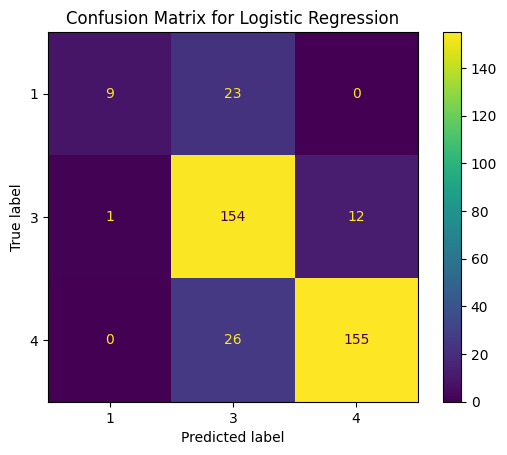

In [151]:
# Entrenamos con el conjunto de train y su target
#X_ttauri_train = X_ttauri_train.select_dtypes(include = 'number')
#X_ttauri_test = X_ttauri_test.select_dtypes(include = 'number')

#logreg.fit(X_ttauri_train, y_ttauri_train['Clase'].values.ravel())

#logreg.fit(X_ttauri_train[['J_H','H_K','Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']],y_ttauri_train)
#logreg.fit(X_ttauri_train[['Halfa','Hbeta','OI','He I','He I b','He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li','Li b']],y_ttauri_train)
logreg.fit(X_ttauri_train,y_ttauri_train)
logreg.coef_.shape


print('Accuracy en train: ', logreg.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ', logreg.score(X_ttauri_test, y_ttauri_test[['Clase']]))

# Calculamos las métricas globales, con el parámetro average

preds_proy = logreg.predict(X_ttauri_test)
probs_proy = logreg.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg.classes_)
disp.plot()
plt.title('Confusion Matrix for Logistic Regression')
plt.savefig('RegLog.png')
plt.show()

In [152]:
X_ttauri_train

,J_H,H_K,Halfa,Hbeta,NII,NIIb,OI,He I,He I b,He I c,He I d,He I e,Na D,Ca II H,Ca II K,Li,Li b,SII,SIIb
647,0.790917,0.361861,0.702765,0.608708,0.633600,0.738340,0.749409,0.481045,0.513812,0.780488,0.811986,0.773994,0.689897,0.452670,0.517682,0.720251,0.695755,0.695455,0.675283
174,0.560805,0.436279,0.716974,0.614115,0.644800,0.737873,0.756501,0.481045,0.486188,0.780488,0.809048,0.769350,0.680872,0.478155,0.526900,0.713987,0.683962,0.684848,0.665590
908,0.701920,0.315039,0.723886,0.614684,0.646400,0.746269,0.747045,0.474052,0.524862,0.785366,0.809929,0.770640,0.681624,0.481998,0.541761,0.713987,0.686321,0.689394,0.672052
634,0.818348,0.417054,0.656682,0.594195,0.600000,0.712687,0.732861,0.481045,0.469613,0.775610,0.810223,0.771930,0.687140,0.468649,0.505267,0.722338,0.693396,0.693939,0.665590
98,0.791222,0.339845,0.716206,0.612692,0.642133,0.744869,0.739953,0.479205,0.524862,0.804878,0.811986,0.772446,0.688894,0.472694,0.533672,0.722338,0.695755,0.696970,0.673667
980,0.676623,0.422326,0.711982,0.608139,0.642400,0.746269,0.742317,0.472580,0.530387,0.780488,0.763514,0.769350,0.677112,0.452063,0.527088,0.718163,0.695755,0.692424,0.667205
862,0.803718,0.377675,0.690092,0.599032,0.622667,0.726213,0.742317,0.482149,0.480663,0.800000,0.812280,0.771672,0.688393,0.457929,0.515425,0.724426,0.700472,0.690909,0.678514
741,0.673880,0.329302,0.725422,0.616107,0.647733,0.745802,0.761229,0.470004,0.519337,0.780488,0.810811,0.768834,0.678366,0.487257,0.537998,0.711900,0.688679,0.690909,0.670436
954,0.703749,0.380155,0.718894,0.613261,0.646667,0.750466,0.754137,0.472580,0.513812,0.780488,0.809929,0.770124,0.679870,0.475728,0.534424,0.711900,0.681604,0.690909,0.673667
375,0.724779,0.488992,0.723886,0.615253,0.646933,0.748134,0.765957,0.472580,0.513812,0.790244,0.810517,0.770898,0.680622,0.486448,0.538563,0.711900,0.686321,0.689394,0.672052


## Arbol de Decisión

Accuracy en train:  0.9298642533936652
Accuracy en test:  0.8657894736842106
Precision: 0.866
Recall 0.866
[[ 20   7   5]
 [  4 149  14]
 [  1  20 160]]


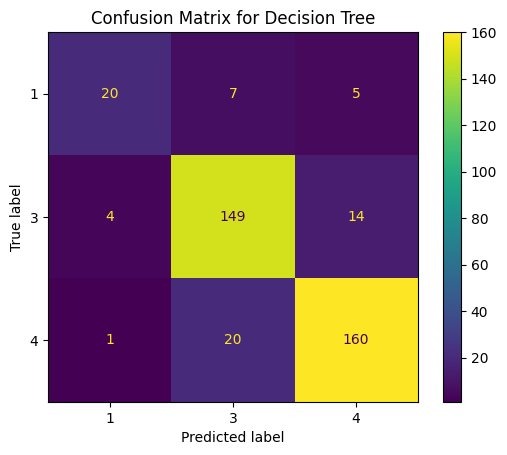

In [153]:
from sklearn.tree import DecisionTreeClassifier

# Inicialiamos con sus parámetros por defecto (salvo la semilla)
#tree_class = DecisionTreeClassifier(random_state = 42)
tree_class = DecisionTreeClassifier(criterion='gini',max_depth=8, random_state=42, splitter='random')

# Entrenamiento
tree_class.fit(X_ttauri_train, y_ttauri_train[['Clase']])
print('Accuracy en train: ',tree_class.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ', tree_class.score(X_ttauri_test, y_ttauri_test[['Clase']]))

# Calculamos las métricas globales, con el parámetro average

preds_proy = tree_class.predict(X_ttauri_test)
probs_proy = tree_class.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=tree_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=tree_class.classes_)
disp.plot()
plt.title('Confusion Matrix for Decision Tree')
plt.savefig('DecisionTree.png')
plt.show()

## KNN

Accuracy en train:  0.9411764705882353
Accuracy en test:  0.8868421052631579
Precision: 0.887
Recall 0.887
[[ 21   9   2]
 [  4 158   5]
 [  5  18 158]]


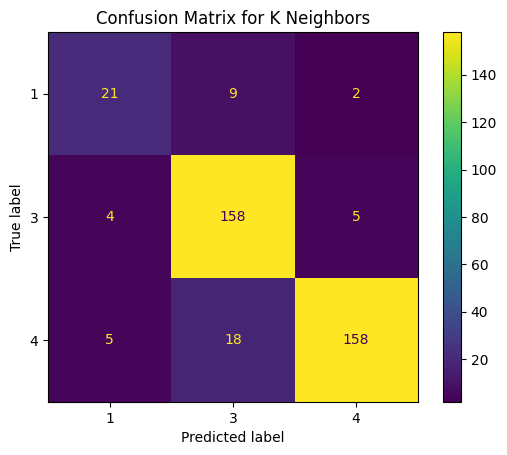

In [154]:
from sklearn.neighbors import KNeighborsClassifier

# Por defecto, k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())
print('Accuracy en train: ',knn.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',knn.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = knn.predict(X_ttauri_test)
probs_proy = knn.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn.classes_)
disp.plot()
plt.title('Confusion Matrix for K Neighbors')
plt.savefig('KNeighbors.png')
plt.show()

## SVC

Accuracy en train:  0.9027149321266968
Accuracy en test:  0.8526315789473684
Precision: 0.853
Recall 0.853
[[ 17  14   1]
 [  3 157   7]
 [  4  27 150]]


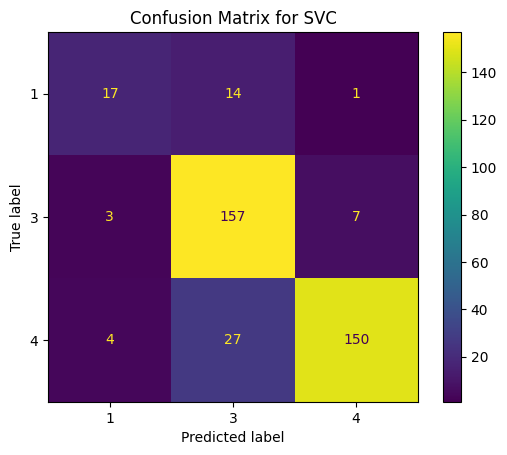

In [155]:
from sklearn.svm import SVC

svc = SVC(random_state=42,probability=True) # parámetros por defecto

svc.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())
print('Accuracy en train: ',svc.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',svc.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = svc.predict(X_ttauri_test)
probs_proy = svc.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc.classes_)
disp.plot()
plt.title('Confusion Matrix for SVC')
plt.savefig('SVC.png')
plt.show()

## MLP

Accuracy en train:  0.8721719457013575
Accuracy en test:  0.8578947368421053
Precision: 0.858
Recall 0.858
[[ 15  17   0]
 [  0 156  11]
 [  0  26 155]]


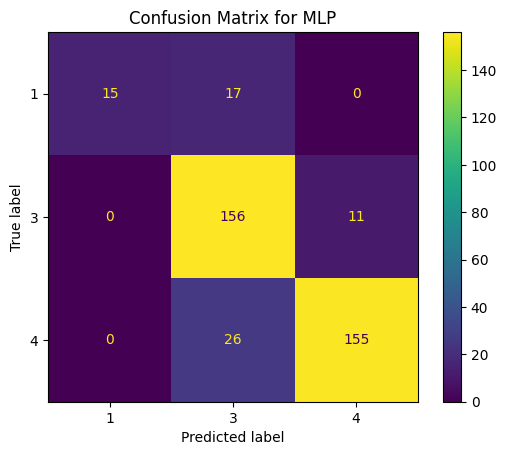

In [156]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state = 42,max_iter=1500)

mlp.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())

print('Accuracy en train: ',mlp.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',mlp.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = mlp.predict(X_ttauri_test)
probs_proy = mlp.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=mlp.classes_)
disp.plot()
plt.title('Confusion Matrix for MLP')
plt.savefig('MLP.png')
plt.show()

## Random Forest

In [157]:
!pip install imblearn

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from joblib import Parallel, delayed, cpu_count

In [159]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [160]:
# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_ttauri_train_resampled, y_ttauri_train_resampled,= smote.fit_resample(X_ttauri_train, y_ttauri_train)

# Entrenar un modelo (ej. RandomForest) con los datos equilibrados
rforest = RandomForestClassifier(random_state=42)

In [166]:
rforest = RandomForestClassifier(
                max_depth=15,
                n_estimators=200,
                criterion='gini',
                #class_weight='balanced',
                class_weight ={1: 2, 2: 1,3:1,4: 1},
                min_samples_leaf=15,
                oob_score=True,
                n_jobs=-1,
                random_state=42,
             )

rforest = RandomForestClassifier(random_state=42)

Accuracy en train:  0.9377828054298643
Accuracy en test:  0.8921052631578947
Precision: 0.892
Recall 0.892
[[ 26   6   0]
 [ 16 146   5]
 [  6   8 167]]


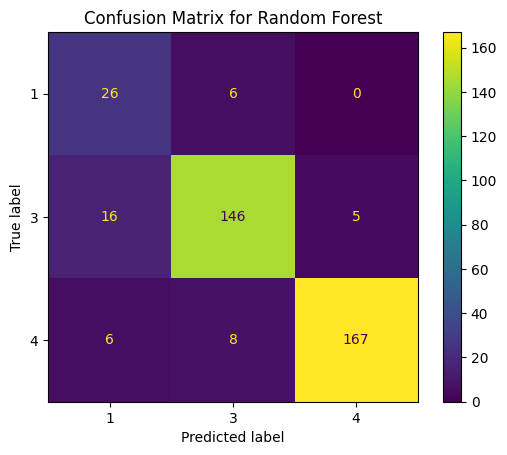

['rforest.joblib']

In [167]:
rforest.fit(X_ttauri_train_resampled, y_ttauri_train_resampled[['Clase']].values.ravel())

print('Accuracy en train: ',rforest.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',rforest.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = rforest.predict(X_ttauri_test)
probs_proy = rforest.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=rforest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rforest.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest')
plt.savefig('RandomForest.png')
plt.show()
dump(rforest, 'rforest.joblib')

Accuracy en train:  0.9366515837104072
Accuracy en test:  0.8947368421052632
Precision: 0.895
Recall 0.895
[[ 24   8   0]
 [ 12 146   9]
 [  1  10 170]]


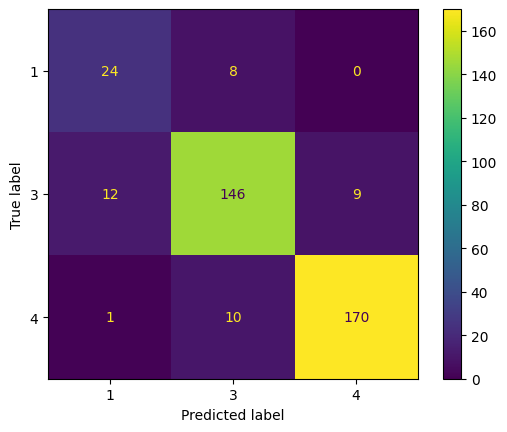

In [168]:
rforest.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())

print('Accuracy en train: ',rforest.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',rforest.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = rforest.predict(X_ttauri_test)
probs_proy = rforest.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=rforest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rforest.classes_)
disp.plot()

plt.show()

#dump(rforest, 'rforest.joblib')

In [169]:
from sklearn.model_selection import GridSearchCV

# Definir el modelo
rforest = RandomForestClassifier(random_state=42, class_weight='balanced', oob_score=True, n_jobs=-1)

# Definir los hiperparámetros para probar
param_grid = {
    'max_depth': [10, 12, 15],
    'n_estimators': [100, 200, 300],
    'min_samples_leaf': [5, 10, 15],
    'criterion': ['gini', 'entropy']
}

# Realizar la búsqueda con validación cruzada
grid_search = GridSearchCV(estimator=rforest, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Ajustar el modelo
grid_search.fit(X_ttauri_train, y_ttauri_train)

# Imprimir los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Evaluar en el conjunto de prueba
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_ttauri_test, y_ttauri_test)
print("Accuracy en test:", test_accuracy)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros encontrados: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 200}
Accuracy en test: 0.9052631578947369


In [ ]:
rforest = RandomForestClassifier(
                max_depth=10,
                n_estimators=200,
                criterion='gini',
                #class_weight='balanced',
                #class_weight ={1: 1, 2: 3, 3: 1, 4: 1},
                min_samples_leaf=10,
                oob_score=True,
                n_jobs=-1,
                random_state=42,
             )

rforest.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())

print('Accuracy en train: ',rforest.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',rforest.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = rforest.predict(X_ttauri_test)
probs_proy = rforest.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=rforest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rforest.classes_)
disp.plot()

plt.show()

## Combinando modelos

In [ ]:
from sklearn.ensemble import VotingClassifier

# Combinamos 
vc = VotingClassifier(estimators = [('mlp',mlp),('logreg',logreg),('tree_class',tree_class),('svc',svc),('knn',knn),('rforest',rforest)])
                      
# ojo con train no con test

vc.fit(X_ttauri_train, y_ttauri_train.values.ravel())

preds_proy = vc.predict(X_ttauri_test)
print('Accuracy modelo combinado: %.3f' % vc.score(X_ttauri_test, y_ttauri_test))

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=vc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=vc.classes_)
disp.plot()

plt.show()

## Optimizando Hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              #{'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]

grid_log = GridSearchCV(estimator = logreg,  
                           param_grid = grid_parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_log.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_log.best_params_)

print(grid_log.best_score_)

print(grid_log.best_estimator_)

# Parámetros de búsqueda y posibles valores
grid_parameters = {'kernel': ['linear', 'rbf', 'poly'], 'C': [10.0, 1.0, 0.1, 0.01, 0.001]}

# Grid search
grid_SVC = GridSearchCV(SVC(random_state=42), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_SVC.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_SVC.best_params_)

print(grid_SVC.best_score_)

print(grid_SVC.best_estimator_)


# Parámetros de búsqueda y posibles valores
grid_parameters = {'hidden_layer_sizes': [(20,), (30,), (15, 15)], 
                   'activation': ['tanh', 'relu'] }

# Grid search
grid_MLP = GridSearchCV(MLPClassifier(random_state=42,max_iter=15000), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_MLP.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_MLP.best_params_)

print(grid_MLP.best_score_)

print(grid_MLP.best_estimator_)


# Parámetros de búsqueda y posibles valores
grid_parameters = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'],'max_depth' : [1,2,3,4,5,6,7,8] }

# Grid search
grid_Tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_Tree.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_Tree.best_params_)

print(grid_Tree.best_score_)

print(grid_Tree.best_estimator_)

# Parámetros de búsqueda y posibles valores
k_range = list(range(1, 31))
grid_parameters = dict(n_neighbors=k_range)

# Grid search
grid_KNN = GridSearchCV(KNeighborsClassifier(),param_grid = grid_parameters, cv = 10, scoring = 'accuracy')

# Comenzamos el entrenamiento
grid_KNN.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_KNN.best_params_)

print(grid_KNN.best_score_)

print(grid_KNN.best_estimator_)

# Parámetros de búsqueda y posibles valores

param_grid = {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }

grid_rforest = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_rforest.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_rforest.best_params_)

print(grid_rforest.best_score_)

print(grid_rforest.best_estimator_)


vc = VotingClassifier(estimators = [('mlp',mlp),('logreg',logreg),('tree_class',tree_class),('svc',svc),('knn',knn),('rforest',rforest)])
                      
# ojo con train no con test

vc.fit(X_ttauri_train, y_ttauri_train.values.ravel())


print('Accuracy modelo combinado: %.3f' % vc.score(X_ttauri_test, y_ttauri_test))

# Se almacena el modelo vc
from joblib import dump
import joblib  

dump(vc, 'modelo_combinado_final.joblib')

In [ ]:
preds_proy = vc.predict(X_ttauri_test)
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=vc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=vc.classes_)
disp.plot()

plt.show()

## Selección de Variables

In [ ]:
X_ttauri_train

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Para clasificación
selector = SelectKBest(chi2, k=5)
X_ttauri_select = selector.fit_transform(X_ttauri_train, y_ttauri_train)

for var, value in zip(selector.feature_names_in_, selector.scores_):
    print('Variable %s: %.4f' % (var, value))

In [ ]:
def evalua_directorio(dir,modelo):
    directorio = dir
    class4 = 0
    class1 = 0
    class2 = 0
    class3 = 0
    total = 0
    
    for filename in os.listdir(directorio):
       filepath = os.path.join(directorio,filename)

       if filepath.endswith('.fits'):
            try:
                # Utilizando 'with' para asegurar que el archivo se cierra correctamente
                with fits.open(filepath) as hdul:
                    clase = 0
                    clase = evalua_estrella(extrae_estrella(filepath,lines),modelo)
                    print(filepath, " , ",clase )
                    if clase == 1:
                            class1+=1
                            total+=1
                    elif clase == 2:
                            class2+=1
                            total+=1
                    elif clase == 3:
                            class3+=1
                            total+=1
                    elif clase == 4:
                            class4+=1
                            total+=1
                    else:
                            total+=1
                        #print(filepath," class: ",clasificacion)
            except Exception as e:
                print(f"No se pudo procesar el archivo {filename}: {e}")

    print ("total: " , total, " clases: ", class1, class1/total, class2, class2/total, class3, class3/total, class4, class4/total) 
     



In [ ]:
import json
def extrae_estrella(file,lines):
    data = []
    file_lines = {label: process_fits_file2(file,label,lines[label]) for label in lines}

    #json_string = json.dumps(file_lines)
   
    #ttauris['Array_Resultado'] = ttauris['Array_Resultado'].apply(safe_literal_eval)
   
    #ttauris = ttauris.join(pd.json_normalize(ttauris['Array_Resultado'])).drop(columns=['Array_Resultado'])
            
    jh,hk = obtenerJH_HK(file)
    ra,dec = radec_header_fits(file)
    oid = keyword_header_fits(file,"OBSID")
                                
    # Añadir al dataset
    data.append({
               "Nombre_Fichero": file,
                "RA": ra,
                "DEC": dec,
                "OID": oid,
                "J_H": jh,
                "H_K": hk
                }) 

    #lineas = json.loads(json_string)

    #print(data)
    #print(type(data))

    #print(file_lines)
    #print(type(file_lines))

    #data = dict(data) | dict(file_lines)

    #diccionario_unido = {**data[0], **file_lines}

    # Crear una nueva lista que contenga el diccionario unido
    #lista_final = [diccionario_unido]

    # Mostrar el resultado
    #print(lista_final)

    
    # Convertir la lista de datos a DataFrame
    #df = pd.DataFrame(lista_final)
    df = pd.DataFrame([ {**data[0], **file_lines}])
    
    # Guardar el DataFrame en un archivo CSV
    #df.to_csv(f"{path}{fichero_variables}", index=False)

    #print("El procesamiento ha finalizado y los resultados se han guardado en",path)
    
    return df
    

In [ ]:
extrae_estrella("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp06-029.fits",lines)

In [ ]:
def evalua_estrella(star,modelo):

    #star = star.join(pd.json_normalize(star['Array_Resultado'])).drop(columns=['Array_Resultado'])
    clasificacion = modelo.predict(star[['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                    'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                    'Li b', 'SII', 'SIIb']])
    return (clasificacion[0])
    

In [ ]:
evalua_estrella(extrae_estrella("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp06-160.fits",lines),rforest)

In [ ]:
#evalua_directorio("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\",rforest)

In [ ]:
#evalua_directorio("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\ClassicWeak\\fits\\",rforest)

In [ ]:
#evalua_directorio("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Weak\\fits\\",rforest)

In [ ]:
#evalua_directorio("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\",rforest)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Función modificada para aceptar un único array con las coordenadas y paralaje
def representar_estrellas_3d(estrellas):
    # Separar las columnas del array de estrellas (RA, DEC, paralaje)
    ascensiones = estrellas[:, 0]  # RA
    declinaciones = estrellas[:, 1]  # DEC
    paralajes = estrellas[:, 2]  # paralaje en milisegundos de arco
    
    # Convertir paralajes a distancias en parsecs
    distancias = 1 / (paralajes / 1000)  # Paralajes en milisegundos de arco a parsecs
    
    # Crear el gráfico 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Representar RA en el eje X, DEC en el eje Y, y la distancia en el eje Z
    ax.scatter(ascensiones, distancias, declinaciones, c='b', marker='o')
    
    # Etiquetas de los ejes
    ax.set_xlabel('RA (grados)')
    ax.set_zlabel('DEC (grados)')
    ax.set_ylabel('Distancia (parsecs)')
    
    plt.show()
    
    plt.show()

In [ ]:
extrae_estrella("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp04-134.fits",lines)['RA']


In [ ]:
evalua_estrella(extrae_estrella("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp04-134.fits",lines),rforest)

In [ ]:
radec_header_fits("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp04-134.fits")


In [ ]:
obtenerJH_HK("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp04-134.fits")


In [ ]:
obtener_datos_gaia(ra, dec)

In [ ]:
extrae_estrella("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\spec-56617-VB081S05V1_sp06-029.fits",lines)

In [ ]:
def representa_directorio(dir,modelo):
    directorio = dir
    estrellas=[] 
    for filename in os.listdir(directorio):
       filepath = os.path.join(directorio,filename)

       if filepath.endswith('.fits'):
            try:
                # Utilizando 'with' para asegurar que el archivo se cierra correctamente
                with fits.open(filepath) as hdul:
                    clase = 0
                    clase = evalua_estrella(extrae_estrella(filepath,lines),modelo)
                    ra,dec = radec_header_fits(filepath)
                    jh,hk = obtenerJH_HK(filepath)
                    parallax, radial_velocity, distance = obtener_datos_gaia(ra, dec)
                    estrellas.append({
                       "Nombre_Fichero": filename,
                       "RA": ra,
                       "DEC": dec,
                       "parallax":parallax,
                       "radial_velocity":radial_velocity,
                       "distancia":distance,
                       "J_H": jh,
                       "H_K": hk,
                       "clase": clase
                    })                                        
            except Exception as e:
                print(f"No se pudo procesar el archivo {filename}: {e}")   
                
      
       array = np.array([[d['RA'], d['DEC'], d['parallax']] for d in estrellas])
       
    representar_estrellas_3d(array)       

In [ ]:
representa_directorio("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits",rforest)